# Anomaly detection in energy storage systems.

# Overview
With the increasing number of pneumonia cases during COVID hospitals are overwhelmed with additional work. Some of the methods that are used to diagnosed COVID is by making X rays of chrest. I was hired by a local hospital to create a model that can automatically classify person on having or not pneumonia based on X-ray. This system should have high accuracy and high recall.

To acheive this goal, We used image recognition with DeepLearning techniques including CNN and pretrained CNN. 


# Business Understanding
Our stakeholder wants to have model that can be reliable in predicting when person have pneumonia.

# Data

1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3


# Metrics
#### Our project will answer following question:
Can we predict people with pneumonia based on their chrest X-ray?

#### Hypothesis:
H0 - Person has pneumonia

HA - There is statisticaly significant proof that the preson doesnt' have pneumonia

#### TP, TN, FP, FN definition
TP - we predicted pneumonia and it actually exist.

TN - we predicted that person didn't have pneumonia and the person actually didn't have it.

FP - We predicted pneumonia but there was no pneumonia in real life.

FN - We predicted that there is no pneumonia but it actually existed.


#### Metrics used  
To compare models we will focus on 2 major metrics:

Recall - Health of people is our priority, we will be focused to minimize FN.
##### Business requirement: our system should have at least 95% recall. 

Accuracy - how good we can predict TP and TN. General metrics that will show model performance.




# Data Understanding
#### Sources of data:
1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3

#### Main dataset contains the following images:
Train set:

There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg

There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg

Test set:

There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg

There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


# Data Cleaning
### Importing required modules

In [953]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import re
#import cv2



%matplotlib inline


# Work with data
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


#Other
import pickle
import time
import os, shutil 
from PIL import Image
from scipy import ndimage
import itertools

import zipfile
import os
#import cv2

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
# simplefilter(action='ignore', category= FutureWarning)
# simplefilter(action='ignore', category= ConvergenceWarning)
# simplefilter(action='ignore', category= FitFailedWarning)
# simplefilter(action='ignore', category= UserWarning)

### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [1266]:
# config
low_voltage_th = -3
low_voltage_alarm = -2
high_voltage_th = 3
high_voltage_alarm = 2
low_temperature = 100
high_temperature = 100
high_mean_temperature_alarm = 400
low_mean_temperature_alarm = 50

sns.set_style("whitegrid")


In [138]:
# Data folder
raw_folder = "raw/"

In [139]:
# Files inside
files = [file for file in os.listdir(raw_folder) if file.endswith("csv")]

In [1170]:
#os.listdir(raw_folder)

In [983]:
# make list of paths
list_paths = [raw_folder + file for file in files]
list_paths

['raw/vol1 20210610 19.csv',
 'raw/vol1 20210610 18.csv',
 'raw/vol1 20210610 17.csv']

In [1003]:
# Create timeseries from files inside the folder
def create_dataframe(list_paths, df_type = "voltage", resample_time= "30S"):
    # read
    files = [list_paths + file for file in os.listdir(list_paths) if file.endswith("csv")]
    df_type = df_type.lower()
    reg = re.compile(df_type)
    dataframe = [pd.read_csv(file) for file in files]
    final_df = pd.concat(dataframe, axis = 0)
    final_df["MCGS_TIME"] = pd.to_datetime(final_df["MCGS_TIME"])
    final_df = final_df.set_index("MCGS_TIME")
    drop_columns = [column for column in final_df.columns.str.lower() if not bool(re.match(reg, column))]
    final_df.columns = final_df.columns.str.lower()
    final_df= final_df.drop(drop_columns, axis = 1)
    final_df = final_df.resample(resample_time).mean().bfill()
    return final_df



In [1000]:
reg = re.compile("[a-zA-Z0-9_]+voltage")


string = "cluster_1_cellvoltage_001"
bool(re.match(reg, string))

True

In [779]:
# dataframe = [pd.read_csv(path) for path in list_paths]
# final_df = pd.concat(dataframe, axis = 0)
# final_df["MCGS_TIME"] = pd.to_datetime(final_df["MCGS_TIME"])
# final_df = final_df.set_index("MCGS_TIME")
# drop_columns = [column for column in final_df.columns.str.lower() if "voltage" not in column]
# # final_df= final_df.drop(drop_columns, axis = 1)
# # final_df = final_df.resample("30S").mean().bfill()

In [793]:
df_30sec = create_dataframe(list_paths)

In [788]:
df_30sec.columns = df_30sec.columns.str.lower()

In [988]:
df_30sec

# Work with clusters

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:00:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:02:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,3383.666667,3386.000000,3383.000000,3391.000000,3387.333333,3383.333333,3385.000000,3379.666667,3384.666667,3384.333333,...,3387.333333,3380.333333,3388.333333,3389.333333,3383.333333,3389.333333,3395.000000,3388.666667,3384.333333,3388.000000
2021-06-10 19:58:00,3385.333333,3387.333333,3384.333333,3392.000000,3388.666667,3384.666667,3386.333333,3381.333333,3386.333333,3386.000000,...,3388.333333,3381.333333,3389.000000,3390.333333,3384.333333,3390.333333,3396.000000,3389.666667,3386.000000,3389.333333
2021-06-10 19:58:30,3386.333333,3388.333333,3385.333333,3393.333333,3389.666667,3385.333333,3387.666667,3382.333333,3387.333333,3386.666667,...,3389.666667,3382.666667,3390.666667,3391.666667,3385.666667,3391.666667,3396.666667,3390.666667,3386.666667,3390.666667


In [1156]:
# Find clusters
clusters = [cluster for cluster in os.listdir(raw_folder) if "cluster" in cluster]
# Prepare path for each cluster
clusters_paths = [(raw_folder + cluster + "/", cluster) for cluster in clusters]

In [1157]:
# Check data sources in each cluster
os.listdir(clusters_path[0][0])
# Divide it cluster to different types of data
voltage_paths = [(cluster_parth[0]+"voltage/", cluster_parth[1]) for cluster_parth in clusters_paths]
temperature_paths = [(cluster_parth[0]+"temperature/", cluster_parth[1]) for cluster_parth in clusters_paths]
state_paths = [(cluster_parth[0]+"total state/", cluster_parth[1]) for cluster_parth in clusters_paths]

# Create datasets
df_voltage_list = [create_dataframe(voltage_path[0], "[a-zA-Z0-9_]+voltage") for voltage_path in voltage_paths]
df_temperature_list = [create_dataframe(temperature_path[0], '[a-zA-Z0-9_]+temperature') for temperature_path in temperature_paths]
df_state_list = [create_dataframe(state_path[0], '[a-zA-Z0-9_]+current$') for state_path in state_paths]

# Check that all datasets in clusters
assert len(df_voltage_list) == len(df_temperature_list)
assert len(df_voltage_list) == len(df_state_list)

# Check that same timeframes
for i in range(len(df_voltage_list)):
    assert all(df_voltage_list[i].index == df_temperature_list[i].index)
#    assert all(df_30sec.index == df_30sec_temperature.index)

result_list = []

for i in range(len(df_voltage_list)):
    final = pd.concat([df_voltage_list[i], df_temperature_list[i], df_state_list[i]], axis = 1)
    result_list.append(final)
    
    



# # Combine
# for i in ra


In [1178]:
# find cell voltage, temperature, state columns
voltage_columns = [column for column in result_list[0].columns if bool(re.match(re.compile("[a-zA-Z0-9_]+voltage"), column))]
temperatrue_columns = [column for column in result_list[0].columns if bool(re.match(re.compile('[a-zA-Z0-9_]+temperature'), column))]
state_column = [column for column in result_list[0].columns if bool(re.match(re.compile('[a-zA-Z0-9_]+current$'), column))]


In [1186]:
result_list[0]
temperatrue_columns

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,cluster1_current
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.000000
2021-06-10 17:00:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.000000
2021-06-10 17:01:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.000000
2021-06-10 17:01:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.000000
2021-06-10 17:02:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,3383.666667,3386.000000,3383.000000,3391.000000,3387.333333,3383.333333,3385.000000,3379.666667,3384.666667,3384.333333,...,268.0,272.0,276.0,274.0,273.0,269.0,271.0,271.0,271.0,-1147.666667
2021-06-10 19:58:00,3385.333333,3387.333333,3384.333333,3392.000000,3388.666667,3384.666667,3386.333333,3381.333333,3386.333333,3386.000000,...,269.0,273.0,276.0,275.0,274.0,269.0,272.0,272.0,272.0,-1146.666667
2021-06-10 19:58:30,3386.333333,3388.333333,3385.333333,3393.333333,3389.666667,3385.333333,3387.666667,3382.333333,3387.333333,3386.666667,...,269.0,274.0,277.0,276.0,274.0,270.0,272.0,273.0,272.0,-1146.333333


In [980]:
# reg = re.compile("voltage")


# string = "last"
# bool(re.match(reg, string))"[a-zA-Z0-9_]+voltage"

False

In [884]:
df_30sec = create_dataframe(voltage_paths[0][0])

In [839]:
voltage_paths

[('raw/cluster 1/voltage/', 'cluster 1'),
 ('raw/cluster 2/voltage/', 'cluster 2')]

In [882]:
df_30sec.index == df_30sec_temperature.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [877]:
df_30sec
df_30sec_temperature = create_dataframe(temperature_paths[0][0], "temperature")
df_30sec_status = create_dataframe(state_paths[0][0], "cluster1_current")

,cluster_1_temperature_001,cluster_1_temperature_002,cluster_1_temperature_003,cluster_1_temperature_004,cluster_1_temperature_005,cluster_1_temperature_006,cluster_1_temperature_007,cluster_1_temperature_008,cluster_1_temperature_009,cluster_1_temperature_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,target
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:00:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:01:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:01:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:02:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,279.0,273.0,272.0,271.0,273.0,276.0,277.0,274.0,273.0,275.0,...,268.0,272.0,276.0,274.0,273.0,269.0,271.0,271.0,271.0,1
2021-06-10 19:58:00,279.0,274.0,272.0,272.0,274.0,277.0,278.0,275.0,274.0,276.0,...,269.0,273.0,276.0,275.0,274.0,269.0,272.0,272.0,272.0,1
2021-06-10 19:58:30,280.0,275.0,273.0,273.0,275.0,277.0,279.0,276.0,275.0,276.0,...,269.0,274.0,277.0,276.0,274.0,270.0,272.0,273.0,272.0,1


In [928]:
df_30sec_temperature

,cluster_1_temperature_001,cluster_1_temperature_002,cluster_1_temperature_003,cluster_1_temperature_004,cluster_1_temperature_005,cluster_1_temperature_006,cluster_1_temperature_007,cluster_1_temperature_008,cluster_1_temperature_009,cluster_1_temperature_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,target
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:00:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:01:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:01:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
2021-06-10 17:02:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,279.0,273.0,272.0,271.0,273.0,276.0,277.0,274.0,273.0,275.0,...,268.0,272.0,276.0,274.0,273.0,269.0,271.0,271.0,271.0,1
2021-06-10 19:58:00,279.0,274.0,272.0,272.0,274.0,277.0,278.0,275.0,274.0,276.0,...,269.0,273.0,276.0,275.0,274.0,269.0,272.0,272.0,272.0,1
2021-06-10 19:58:30,280.0,275.0,273.0,273.0,275.0,277.0,279.0,276.0,275.0,276.0,...,269.0,274.0,277.0,276.0,274.0,270.0,272.0,273.0,272.0,1


In [760]:
dataframe = [pd.read_csv(path) for path in list_paths]

<AxesSubplot:xlabel='MCGS_TIME'>

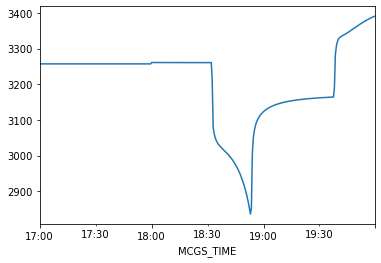

In [908]:
mean_30sec.plot()

In [909]:
mean_30sec = np.mean(df_30sec, axis = 1)
adfuller(mean_30sec)

(-1.2591554137581482,
 0.6476455750640476,
 2,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 2642.267311124226)

<AxesSubplot:xlabel='MCGS_TIME'>

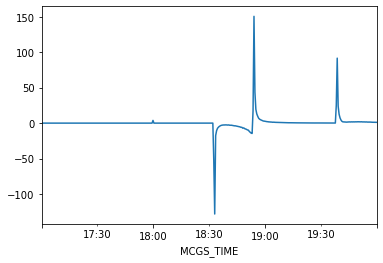

In [907]:
roll_mean = mean_30sec.diff(periods=1).dropna()
roll_mean.plot()

In [826]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [827]:
adfuller(roll_mean)

(-10.642696051524512,
 4.883733815473972e-19,
 1,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 2635.087088248933)

In [910]:
model = sm.tsa.statespace.SARIMAX(mean_30sec, order = (3,1,2),  enforce_stationarity=False,
                                            enforce_invertibility=False)

In [911]:
# Fit the model and print results
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78973D+00    |proj g|=  1.57987D-03

At iterate    5    f=  3.78968D+00    |proj g|=  3.77314D-03

At iterate   10    f=  3.78966D+00    |proj g|=  6.63159D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   1.586D-05   3.790D+00
  F =   3.7896569397777551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1364.276
Date:                Thu, 24 Feb 2022   AIC                           2740.553
Time:                        13:19:11   BIC                           2763.803
Sample:                    06-10-2021   HQIC                          2749.801
                         - 06-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5764      7.724      0.075      0.941     -14.562      15.715
ar.L2         -0.0239      1.699     -0.014      0.989      -3.353       3.305
ar.L3          0.0015      1.357      0.001      0.999      -2.659       2.662
ma.L1         -0.0716      7.734     -0.009      0.993     -15.230      15.087
ma.L2         -0.1236      4.016     -0.031      0.975      -7.995       7.748
sigma2       124.7758      2.852     43.751      0.000     119.186     130.366
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            138395.00
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             396.87   Skew:                             4.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [250]:
mean_30sec

MCGS_TIME
2021-06-10 17:00:00    3256.975000
2021-06-10 17:00:30    3256.975000
2021-06-10 17:01:00    3256.975000
2021-06-10 17:01:30    3256.975000
2021-06-10 17:02:00    3256.975000
                          ...     
2021-06-10 19:57:30    3385.766667
2021-06-10 19:58:00    3386.925000
2021-06-10 19:58:30    3388.094444
2021-06-10 19:59:00    3389.209722
2021-06-10 19:59:30    3390.330556
Freq: 30S, Length: 360, dtype: float64

In [918]:
pred = result.get_prediction(start = "2021-06-10 17:30:00", dynamic = False)
pred_conf = pred.conf_int(alpha=0.005)

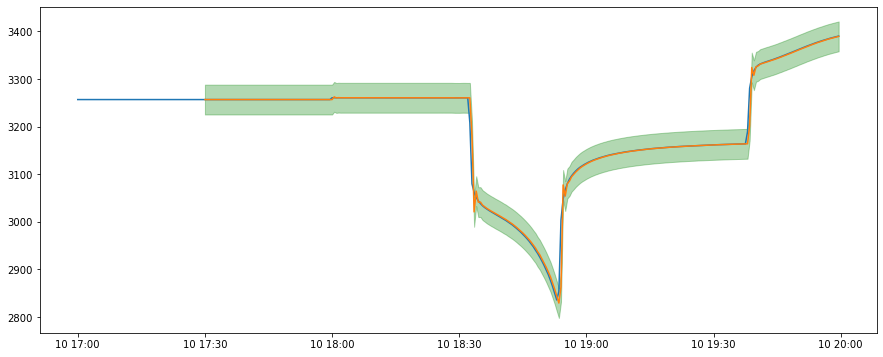

In [1027]:
# Plot real vs predicted values along with confidence interval
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
plt.plot(mean_30sec, label='observed')

# Plot predicted values
plt.plot(pred.predicted_mean, label = "predicted")

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0],
                 pred_conf.iloc[:,1], color = "green", alpha = 0.3)



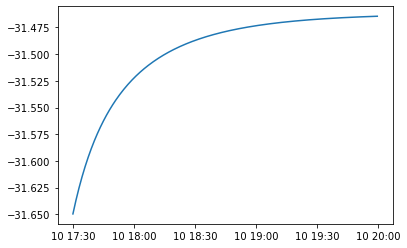

In [288]:
# plot boundaries 
plt.plot(pred.predicted_mean - pred_conf.iloc[:,1], label = "predicted")

16.32642705227356

<AxesSubplot:xlabel='MCGS_TIME'>

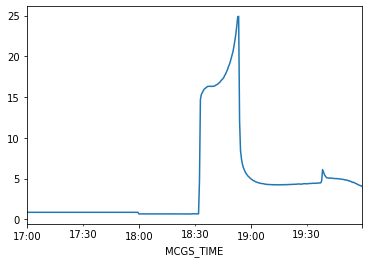

In [294]:
np.std(df_30sec, axis = 1).plot()

In [828]:
np.std(df_30sec.loc['2021-06-10 18:40:00',:])*2

32.65285410454712

In [829]:
df_30sec

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:00:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:02:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,3383.666667,3386.000000,3383.000000,3391.000000,3387.333333,3383.333333,3385.000000,3379.666667,3384.666667,3384.333333,...,3387.333333,3380.333333,3388.333333,3389.333333,3383.333333,3389.333333,3395.000000,3388.666667,3384.333333,3388.000000
2021-06-10 19:58:00,3385.333333,3387.333333,3384.333333,3392.000000,3388.666667,3384.666667,3386.333333,3381.333333,3386.333333,3386.000000,...,3388.333333,3381.333333,3389.000000,3390.333333,3384.333333,3390.333333,3396.000000,3389.666667,3386.000000,3389.333333
2021-06-10 19:58:30,3386.333333,3388.333333,3385.333333,3393.333333,3389.666667,3385.333333,3387.666667,3382.333333,3387.333333,3386.666667,...,3389.666667,3382.666667,3390.666667,3391.666667,3385.666667,3391.666667,3396.666667,3390.666667,3386.666667,3390.666667


In [830]:
df_30sec

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:00:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:01:30,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
2021-06-10 17:02:00,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3258.000000,3258.000000,3257.000000,3257.000000,3258.000000,...,3259.000000,3258.000000,3257.000000,3258.000000,3259.000000,3258.000000,3257.000000,3256.000000,3258.000000,3256.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,3383.666667,3386.000000,3383.000000,3391.000000,3387.333333,3383.333333,3385.000000,3379.666667,3384.666667,3384.333333,...,3387.333333,3380.333333,3388.333333,3389.333333,3383.333333,3389.333333,3395.000000,3388.666667,3384.333333,3388.000000
2021-06-10 19:58:00,3385.333333,3387.333333,3384.333333,3392.000000,3388.666667,3384.666667,3386.333333,3381.333333,3386.333333,3386.000000,...,3388.333333,3381.333333,3389.000000,3390.333333,3384.333333,3390.333333,3396.000000,3389.666667,3386.000000,3389.333333
2021-06-10 19:58:30,3386.333333,3388.333333,3385.333333,3393.333333,3389.666667,3385.333333,3387.666667,3382.333333,3387.333333,3386.666667,...,3389.666667,3382.666667,3390.666667,3391.666667,3385.666667,3391.666667,3396.666667,3390.666667,3386.666667,3390.666667


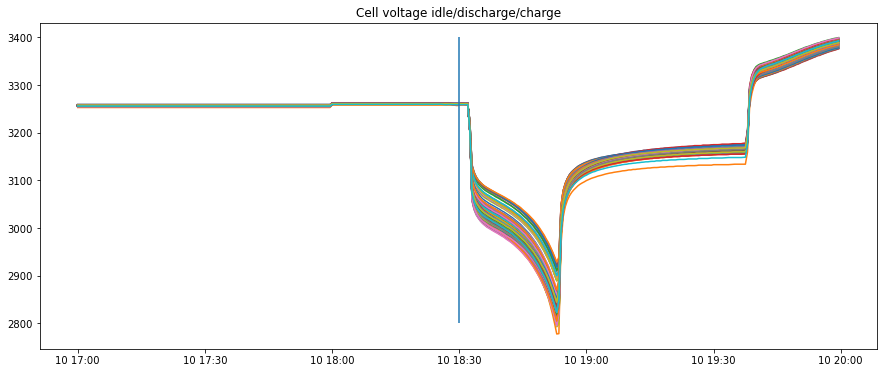

In [831]:
fig, axs = plt.subplots(figsize = (15, 6))
plt.plot(df_30sec)
axs.set_title("Cell voltage idle/discharge/charge")
plt.vlines(x = df_30sec.index[180],ymin = 2800, ymax = 3400)
plt.show()


Voltage mean : 3.26 V
Voltage standard deviation : 0.0007 V


<AxesSubplot:>

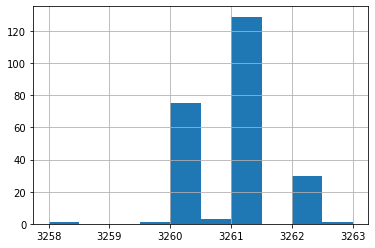

In [832]:
# Lets check voltage sensor reading distribution during different moments of time.
# idle
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 18:00:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 18:00:00',:])/1000,4)} V")
df_30sec.loc['2021-06-10 18:00:00',:].hist(bins = 10)


Voltage mean : 3.12 V
Voltage standard deviation : 0.005 V


<AxesSubplot:>

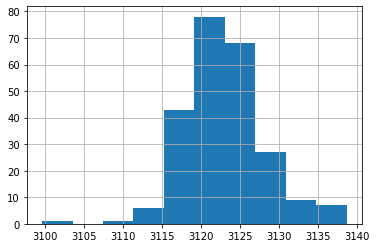

In [833]:
# Start of discharge
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 19:00:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 19:00:00',:]/1000),4)} V")
df_30sec.loc['2021-06-10 19:00:00',:].hist(bins = 10)

Voltage mean : 3.12 V
Voltage standard deviation : 0.005 V


<AxesSubplot:>

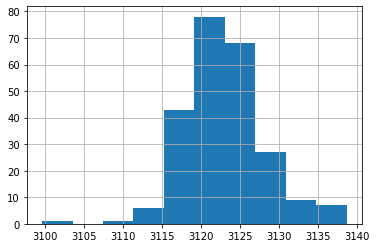

In [834]:
# Resting
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 19:00:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 19:00:00',:]/1000),4)} V")
df_30sec.loc['2021-06-10 19:00:00',:].hist(bins = 10)


Voltage mean : 3.16 V
Voltage standard deviation : 0.0044 V


<AxesSubplot:>

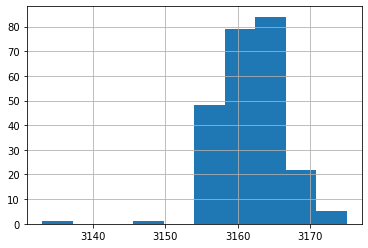

In [835]:
# Charging
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 19:30:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 19:30:00',:]/1000),4)} V")
df_30sec.loc['2021-06-10 19:30:00',:].hist(bins = 10)


Voltage mean : 2.97 V
Voltage standard deviation : 0.0172 V


<AxesSubplot:>

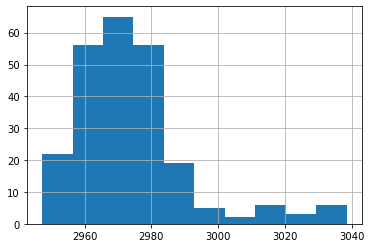

In [836]:
# Middle of discharge
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 18:45:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 18:45:00',:]/1000),4)} V")
df_30sec.loc['2021-06-10 18:45:00',:].hist(bins = 10)

In [460]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

Voltage mean : 2.84 V
Voltage standard deviation : 0.0249 V


<AxesSubplot:>

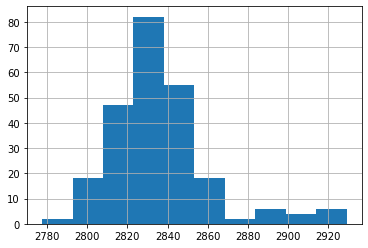

In [462]:
# End of discharge
print(f"Voltage mean : {round(np.mean(df_30sec.loc['2021-06-10 18:53:00',:]/1000),2)} V")
print(f"Voltage standard deviation : {round(np.std(df_30sec.loc['2021-06-10 18:53:00',:]/1000),4)} V")
df_30sec.loc['2021-06-10 18:53:00',:].hist(bins = 10)

In [ ]:
# As we can see voltage of cells is normally distributed

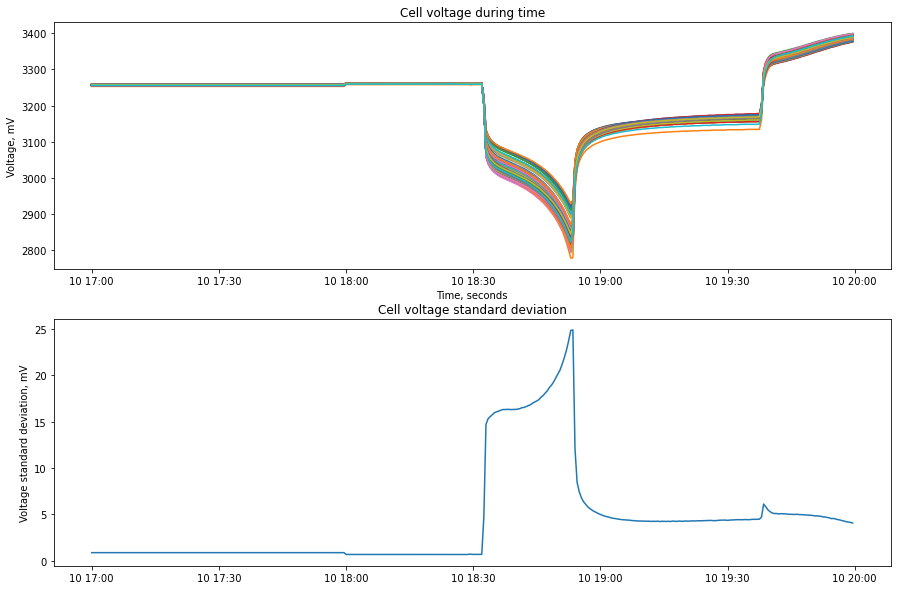

In [888]:
# Lets draw changing of standard deviation of cells during the time
fig, (top, bottom) = plt.subplots(2,1,figsize = (15, 10))
top.plot(df_30sec)
bottom.plot(np.std(df_30sec, axis = 1))
top.set_title("Cell voltage during time")
top.set_ylabel("Voltage, mV")
top.set_xlabel("Time, seconds")
bottom.set_title("Cell voltage standard deviation")
bottom.set_ylabel("Voltage standard deviation, mV")
plt.show()

As we can see, the most voltage difference batteries have at the end of discharge.

This is the moment where cells tend to fail.

##### We are focused on identifing anomalies when cell voltage exceed 3 standard deviations (probability 0.03% from Normal distribution)

##### Check sensor precision based on manufacturer website
http://www.bmser.com/?_l=en

Based on information from website:

"24 Road monomer voltage acquisition (precision <5mV) "
##### We will use 5mV as a minimum threshold during idle time and maximum will be calculated for each point of time based on idea that we should mark sensors that have performance out of range - 3 standard deviation.

### Model preparation

In [490]:
df_custom = pd.DataFrame()

In [1159]:
# Make new boundaries 2 and 3 std
df_custom["mean"] = np.mean(df_30sec, axis = 1)
df_custom["lower_al"] = df_custom["mean"] - 2*np.std(df_30sec, axis = 1)
df_custom["lower"] = df_custom["mean"] - 3*np.std(df_30sec, axis = 1)
df_custom["upper_al"] = df_custom["mean"] + 2*np.std(df_30sec, axis = 1)
df_custom["upper"] = df_custom["mean"] + 3*np.std(df_30sec, axis = 1)

In [1160]:
# Apply sensors precision
df_custom["upper"][df_custom["upper"] - df_custom["mean"] < 5] = df_custom["mean"] + 5
df_custom["lower"][df_custom["lower"] - df_custom["mean"] > -5] = df_custom["mean"] - 5
df_custom["upper_al"][df_custom["upper_al"] - df_custom["mean"] < 5] = df_custom["mean"] + 5
df_custom["lower_al"][df_custom["lower_al"] - df_custom["mean"] > -5] = df_custom["mean"] - 5


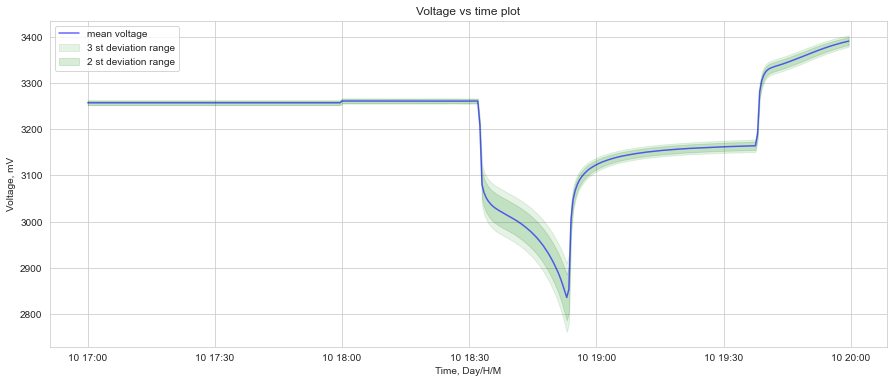

In [1267]:
sns.set_style("whitegrid")
# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
plt.plot(df_custom["mean"], label='mean voltage', color = "blue", alpha = 0.6)

plt.fill_between(df_custom.index, 
                 df_custom["lower"],
                 df_custom["upper"], color = "green", alpha = 0.10, label = "3 st deviation range")

# Plot the range for confidence intervals
plt.fill_between(df_custom.index, 
                 df_custom["lower_al"],
                 df_custom["upper_al"], color = "green", alpha = 0.15, label = "2 st deviation range")
axs.set_title("Voltage vs time plot")
axs.set_xlabel("Time, Day/H/M")
axs.set_ylabel("Voltage, mV")
axs.legend()
plt.show()


In [892]:
list(df_30sec.columns)

['cluster_1_cellvoltage_001',
 'cluster_1_cellvoltage_002',
 'cluster_1_cellvoltage_003',
 'cluster_1_cellvoltage_004',
 'cluster_1_cellvoltage_005',
 'cluster_1_cellvoltage_006',
 'cluster_1_cellvoltage_007',
 'cluster_1_cellvoltage_008',
 'cluster_1_cellvoltage_009',
 'cluster_1_cellvoltage_010',
 'cluster_1_cellvoltage_011',
 'cluster_1_cellvoltage_012',
 'cluster_1_cellvoltage_013',
 'cluster_1_cellvoltage_014',
 'cluster_1_cellvoltage_015',
 'cluster_1_cellvoltage_016',
 'cluster_1_cellvoltage_017',
 'cluster_1_cellvoltage_018',
 'cluster_1_cellvoltage_019',
 'cluster_1_cellvoltage_020',
 'cluster_1_cellvoltage_021',
 'cluster_1_cellvoltage_022',
 'cluster_1_cellvoltage_023',
 'cluster_1_cellvoltage_024',
 'cluster_1_cellvoltage_025',
 'cluster_1_cellvoltage_026',
 'cluster_1_cellvoltage_027',
 'cluster_1_cellvoltage_028',
 'cluster_1_cellvoltage_029',
 'cluster_1_cellvoltage_030',
 'cluster_1_cellvoltage_031',
 'cluster_1_cellvoltage_032',
 'cluster_1_cellvoltage_033',
 'cluster_

In [1163]:
df_30sec["cluster_1_cellvoltage_240"][(df_30sec["cluster_1_cellvoltage_240"] < df_custom["lower"]) & (result_list[0]["cluster1_current"] > 200)]



Series([], Freq: 30S, Name: cluster_1_cellvoltage_240, dtype: float64)

In [1131]:
result_list[0]["cluster1_current"]["2021-06-10 18:53:00"]

1409.5

In [1089]:
df_30sec["cluster_1_cellvoltage_240"]

MCGS_TIME
2021-06-10 17:00:00    3256.000000
2021-06-10 17:00:30    3256.000000
2021-06-10 17:01:00    3256.000000
2021-06-10 17:01:30    3256.000000
2021-06-10 17:02:00    3256.000000
                          ...     
2021-06-10 19:57:30    3388.000000
2021-06-10 19:58:00    3389.333333
2021-06-10 19:58:30    3390.666667
2021-06-10 19:59:00    3391.333333
2021-06-10 19:59:30    3393.000000
Freq: 30S, Name: cluster_1_cellvoltage_240, Length: 360, dtype: float64

In [1268]:
# without status of system
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"])] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        sensor_list.append(sensor_name)
print(sensor_list)

['cluster_1_cellvoltage_023', 'cluster_1_cellvoltage_024', 'cluster_1_cellvoltage_025', 'cluster_1_cellvoltage_026', 'cluster_1_cellvoltage_031', 'cluster_1_cellvoltage_032', 'cluster_1_cellvoltage_052', 'cluster_1_cellvoltage_240']


In [1269]:
# Add status of system
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"]) & (result_list[0]["cluster1_current"] >200)] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        stage = "discharge anomaly"
        sensor_list.append((anomaly, sensor_name, stage))
print(sensor_list)

[(MCGS_TIME
2021-06-10 18:53:30    2778.333333
Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64, 'cluster_1_cellvoltage_052', 'discharge anomaly')]


1

In [ ]:
# Temperature monitoring

<AxesSubplot:>

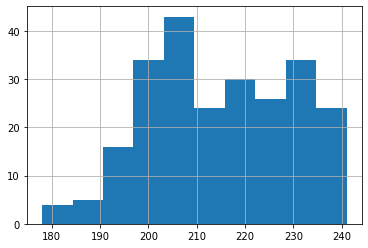

In [1227]:
# Explore data distribution
# Idle
df_temperatures.loc["2021-06-10 17:40:00",:].hist()

<AxesSubplot:>

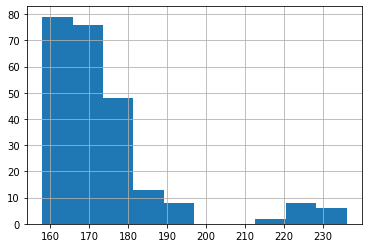

In [1228]:
# Explore data distribution
# discharge
df_temperatures.loc["2021-06-10 18:10:00",:].hist()

<AxesSubplot:>

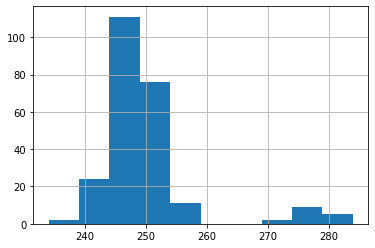

In [1229]:
# Explore data distribution
# idel
df_temperatures.loc["2021-06-10 19:00:00",:].hist()

<AxesSubplot:>

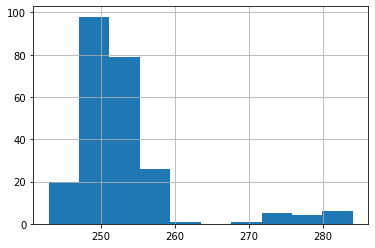

In [1230]:
# Explore data distribution
# charge
df_temperatures.loc["2021-06-10 19:30:00",:].hist()

In [ ]:
# We can clearly see "hot regions" that probably formed due to cooled air distribution
# Batteries recommended temperature should be within 10-40 degrees range. 
# Lets define 

In [1234]:
df_temperatures = result_list[0][temperatrue_columns]
# Mean temperature
df_temp = pd.DataFrame()
df_temp["mean"] = np.mean(df_temperatures, axis = 1)
df_temp["lower_al"] = df_temp["mean"] - low_temperature
df_temp["lower"] = df_temp["mean"] - low_temperature
df_temp["upper_al"] = df_temp["mean"] + high_temperature
df_temp["upper"] = df_temp["mean"] + high_temperature

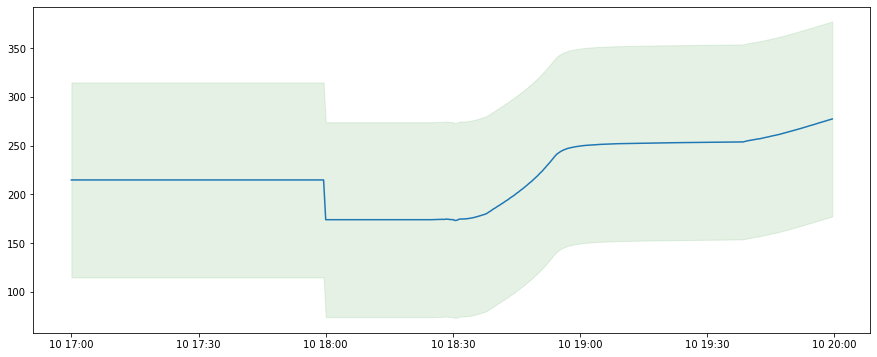

In [1238]:
low_temperature = 100
high_temperature = 100
high_mean_temperature_alarm = 40
Low_mean_temperature_alarm = 5


# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
plt.plot(df_temp["mean"], label='mean voltage')

plt.fill_between(df_temp.index, 
                 df_temp["lower"],
                 df_temp["upper"], color = "green", alpha = 0.05)

# Plot the range for confidence intervals
plt.fill_between(df_temp.index, 
                 df_temp["lower_al"],
                 df_temp["upper_al"], color = "green", alpha = 0.05)

In [1207]:
df_temperatures

,cluster_1_temperature_001,cluster_1_temperature_002,cluster_1_temperature_003,cluster_1_temperature_004,cluster_1_temperature_005,cluster_1_temperature_006,cluster_1_temperature_007,cluster_1_temperature_008,cluster_1_temperature_009,cluster_1_temperature_010,...,cluster_1_temperature_231,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,232.0,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0
2021-06-10 17:00:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,232.0,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0
2021-06-10 17:01:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,232.0,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0
2021-06-10 17:01:30,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,232.0,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0
2021-06-10 17:02:00,214.0,203.0,189.0,187.0,204.0,226.0,233.0,232.0,234.0,235.0,...,232.0,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 19:57:30,279.0,273.0,272.0,271.0,273.0,276.0,277.0,274.0,273.0,275.0,...,275.0,268.0,272.0,276.0,274.0,273.0,269.0,271.0,271.0,271.0
2021-06-10 19:58:00,279.0,274.0,272.0,272.0,274.0,277.0,278.0,275.0,274.0,276.0,...,276.0,269.0,273.0,276.0,275.0,274.0,269.0,272.0,272.0,272.0
2021-06-10 19:58:30,280.0,275.0,273.0,273.0,275.0,277.0,279.0,276.0,275.0,276.0,...,276.0,269.0,274.0,277.0,276.0,274.0,270.0,272.0,273.0,272.0


In [1247]:
# Add status of system
sensor_list = []
for sensor in list(df_temperatures.columns):
    anomaly = df_temperatures[sensor][(df_temp["mean"] > high_mean_temperature_alarm) | 
                                      (df_temp["mean"] < low_mean_temperature_alarm) |
                                      (df_temperatures[sensor] < df_temp["lower"]) | 
                                      (df_temperatures[sensor] > df_temp["upper"])]
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        stage = "temperature anomaly"
        sensor_list.append((anomaly, sensor_name, stage))
print(sensor_list)

[]


In [ ]:
result_list[0]
temperatrue_columns

In [1150]:

for sensor in list(df_30sec.columns):
    if df_30sec[sensor][df_30sec[sensor] < df_custom["lower"]].sum() > 0:
        print(sensor)


cluster_1_cellvoltage_023
cluster_1_cellvoltage_024
cluster_1_cellvoltage_025
cluster_1_cellvoltage_026
cluster_1_cellvoltage_031
cluster_1_cellvoltage_032
cluster_1_cellvoltage_052
cluster_1_cellvoltage_240


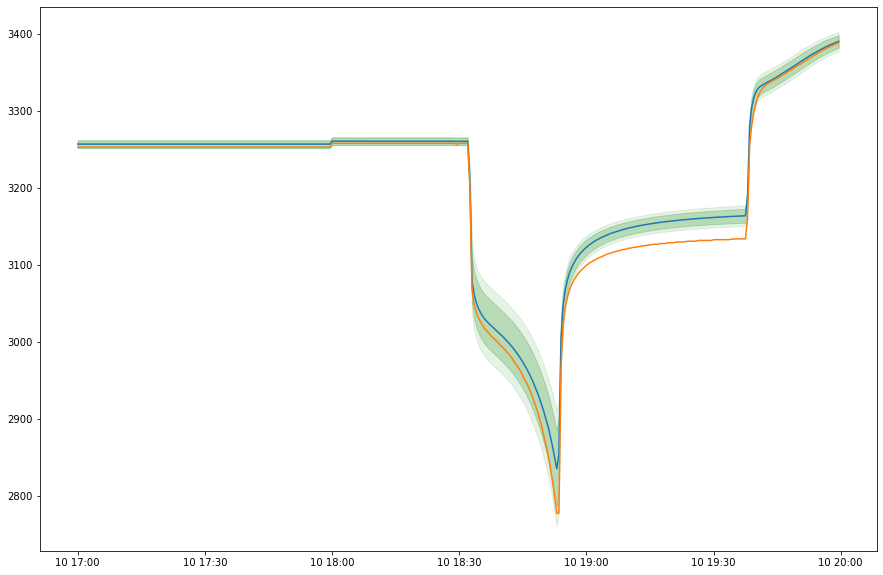

In [1169]:
# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (15, 10))

# Plot observed values
plt.plot(df_custom["mean"], label='mean voltage')
[plt.plot(df_30sec[sensor[1]]) for sensor in sensor_list]


plt.fill_between(df_custom.index, 
                 df_custom["lower"],
                 df_custom["upper"], color = "green", alpha = 0.1)

# Plot the range for confidence intervals
plt.fill_between(df_custom.index, 
                 df_custom["lower_al"],
                 df_custom["upper_al"], color = "green", alpha = 0.2)

In [672]:
(df_30sec.loc[:,"Cluster_1_CellVoltage_052"] < df_custom["lower"]).sum()

83

In [319]:
np.mean(df_30sec.loc['2021-06-10 18:42:00',:])

2996.9875

In [320]:
np.std(df_30sec.loc['2021-06-10 18:42:00',:])

16.544086200042734

In [323]:
np.mean(df_30sec.loc['2021-06-10 18:42:00',:]) - 2* np.std(df_30sec.loc['2021-06-10 18:42:00',:])

2963.8993275999146

In [ ]:
# Plot real vs predicted values along with confidence interval
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
#plt.plot(mean_30sec, label='observed')

# Plot predicted values
plt.plot(mean_30sec, label = "predicted")

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0],
                 pred_conf.iloc[:,1], color = "green", alpha = 0.3)

<AxesSubplot:xlabel='MCGS_TIME'>

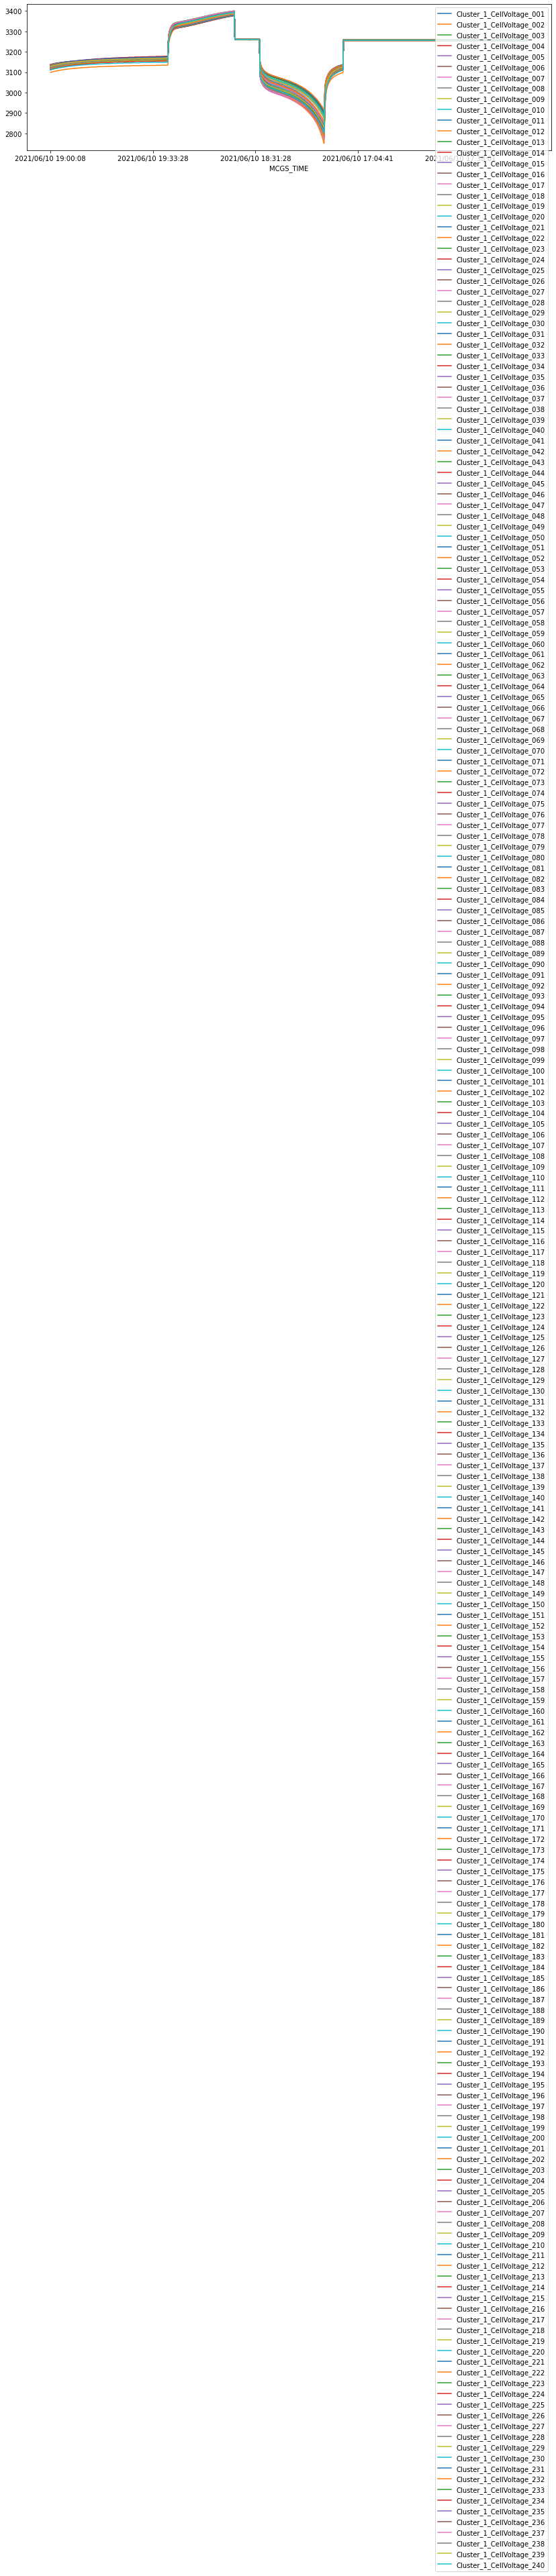

In [176]:
final_df.shape

fig, axs = plt.subplots(1,1, figsize = (14,4))
final_df.plot(ax = axs)

<AxesSubplot:xlabel='MCGS_TIME'>

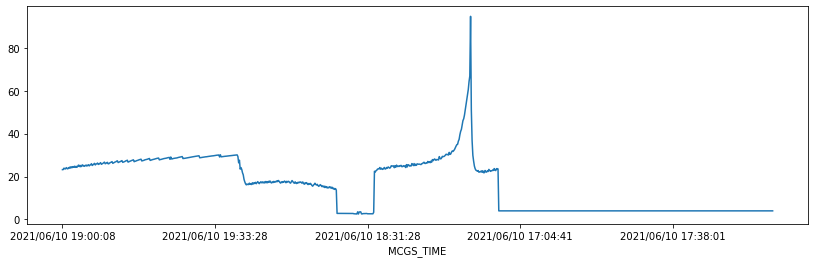

In [158]:
fig, axs = plt.subplots(1,1, figsize = (14,4))
(np.mean(final_df, axis = 1) - final_df.min(axis = 1)).plot(ax = axs)

In [ ]:
# make mean df

In [101]:
len(final_df.columns)

240

<AxesSubplot:xlabel='MCGS_TIME'>

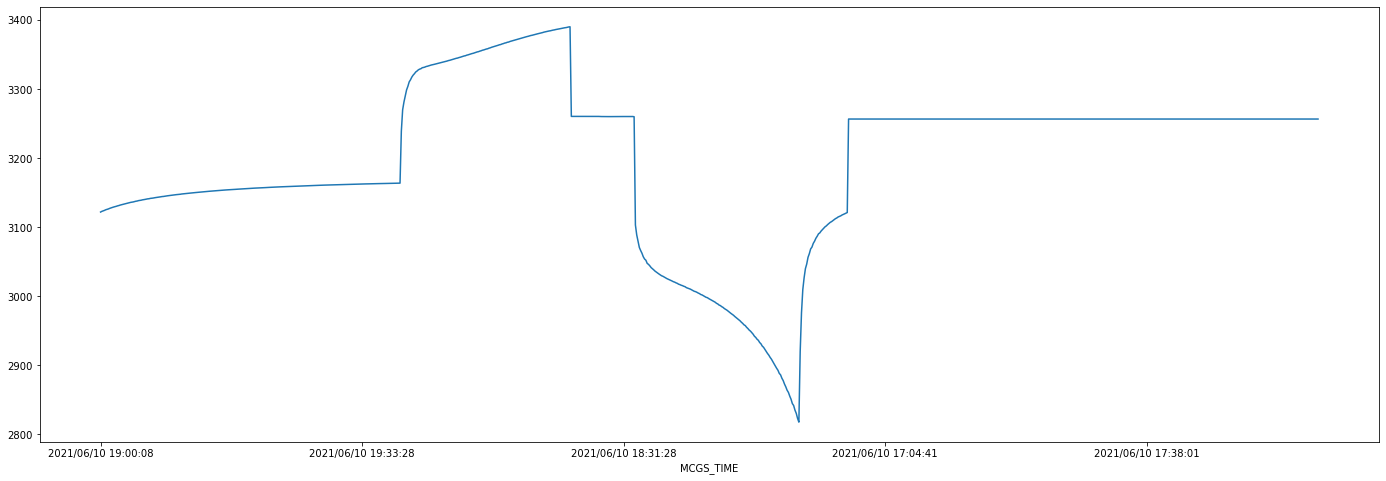

In [143]:
fig, axs = plt.subplots(1,1, figsize = (24,8))
np.mean(final_df, axis = 1).plot(ax = axs)

In [206]:
from statsmodels.tsa.arima_model import ARIMA

model0 = ARIMA(np.mean(df2, axis = 1), dates=None,order=(2,1,0))

In [207]:
result_arima = model0.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39913D+00    |proj g|=  9.09850D-04

At iterate    5    f=  4.39913D+00    |proj g|=  5.93303D-05

At iterate   10    f=  4.39913D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   8.882D-08   4.399D+00
  F =   4.3991296946854632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [209]:
xz = result_arima.predict()

<AxesSubplot:xlabel='MCGS_TIME'>

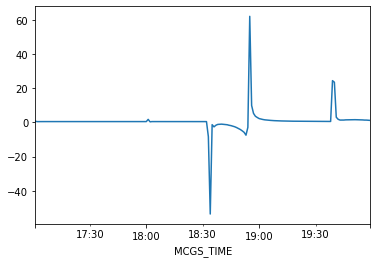

In [211]:
xz.plot()

In [169]:
from statsmodels.tsa.statespace import SARIMAX

ImportError: cannot import name 'SARIMAX' from 'statsmodels.tsa.statespace' (/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/__init__.py)

In [149]:
from statsmodels.tsa.arima_model import ARIMA

model0 = ARIMA(np.mean(final_df, axis = 1), dates=None,order=(2,1,0))

model1 = model0.fit(disp=1)

decomposition = seasonal_decompose(np.array(np.mean(final_df, axis = 1)).reshape(len(np.mean(final_df, axis = 1)),),freq=1)
### insert your data seasonality in 'freq'

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64923D+00    |proj g|=  9.12603D-05

At iterate    1    f=  3.64923D+00    |proj g|=  2.44249D-05

At iterate    2    f=  3.64923D+00    |proj g|=  1.35447D-05

At iterate    3    f=  3.64923D+00    |proj g|=  1.28786D-05

At iterate    4    f=  3.64923D+00    |proj g|=  2.35367D-05

At iterate    5    f=  3.64923D+00    |proj g|=  2.07390D-05

At iterate    6    f=  3.64923D+00    |proj g|=  1.58096D-05

At iterate    7    f=  3.64923D+00    |proj g|=  1.28786D-06

At iterate    8    f=  3.64923D+00    |proj g|=  1.77636D-07

At iterate    9    f=  3.64923D+00    |proj g|=  2.22045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

NameError: name 'seasonal_decompose' is not defined

<AxesSubplot:xlabel='MCGS_TIME'>

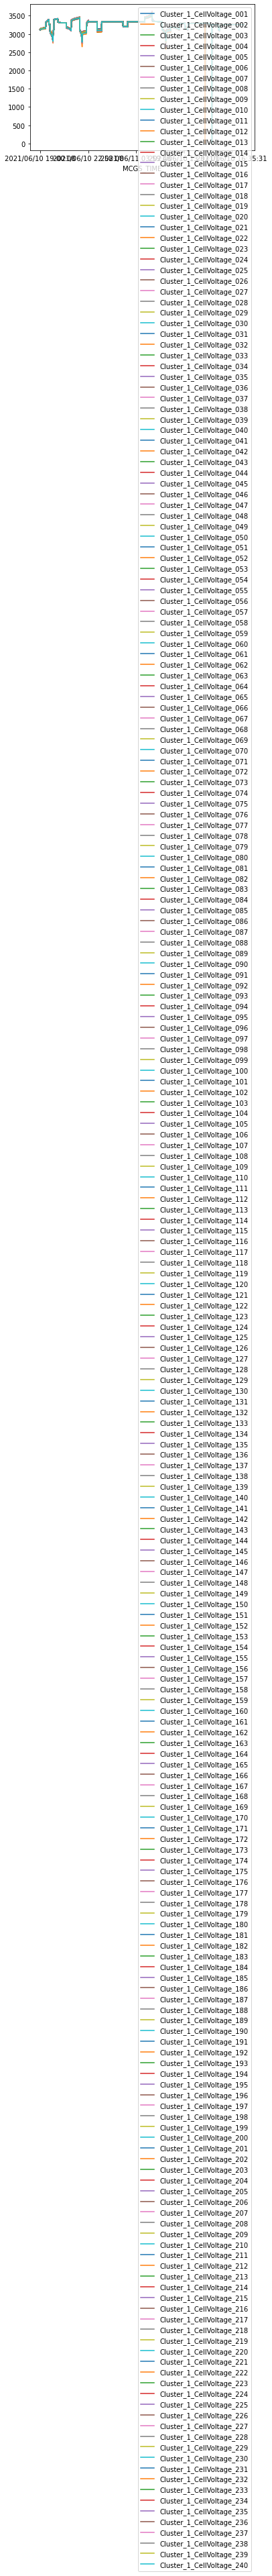

In [133]:
final_df.plot()

,MCGS_TIME,MCGS_TIMEMS,Cluster_1_CellVoltage_001,Cluster_1_CellVoltage_002,Cluster_1_CellVoltage_003,Cluster_1_CellVoltage_004,Cluster_1_CellVoltage_005,Cluster_1_CellVoltage_006,Cluster_1_CellVoltage_007,Cluster_1_CellVoltage_008,...,Cluster_1_CellVoltage_231,Cluster_1_CellVoltage_232,Cluster_1_CellVoltage_233,Cluster_1_CellVoltage_234,Cluster_1_CellVoltage_235,Cluster_1_CellVoltage_236,Cluster_1_CellVoltage_237,Cluster_1_CellVoltage_238,Cluster_1_CellVoltage_239,Cluster_1_CellVoltage_240
0,2021/06/10 19:00:08,678,3121.0,3116.0,3118.0,3119.0,3117.0,3124.0,3124.0,3124.0,...,3130.0,3130.0,3123.0,3122.0,3128.0,3123.0,3121.0,3120.0,3127.0,3110.0
1,2021/06/10 19:00:18,681,3122.0,3117.0,3119.0,3120.0,3118.0,3125.0,3125.0,3125.0,...,3131.0,3131.0,3124.0,3123.0,3129.0,3124.0,3122.0,3122.0,3128.0,3111.0
2,2021/06/10 19:00:28,684,3122.0,3118.0,3120.0,3121.0,3119.0,3126.0,3126.0,3126.0,...,3132.0,3131.0,3124.0,3124.0,3130.0,3125.0,3123.0,3122.0,3128.0,3112.0
3,2021/06/10 19:00:38,679,3123.0,3119.0,3120.0,3121.0,3120.0,3126.0,3127.0,3127.0,...,3132.0,3132.0,3125.0,3125.0,3130.0,3126.0,3123.0,3123.0,3129.0,3113.0
4,2021/06/10 19:00:48,678,3124.0,3120.0,3121.0,3123.0,3120.0,3127.0,3127.0,3128.0,...,3133.0,3133.0,3126.0,3126.0,3131.0,3127.0,3124.0,3124.0,3130.0,3114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021/06/10 18:59:18,683,3117.0,3112.0,3114.0,3115.0,3113.0,3120.0,3120.0,3120.0,...,3126.0,3126.0,3119.0,3118.0,3124.0,3119.0,3116.0,3116.0,3123.0,3106.0
208,2021/06/10 18:59:28,680,3118.0,3113.0,3115.0,3116.0,3113.0,3121.0,3121.0,3121.0,...,3127.0,3127.0,3119.0,3119.0,3124.0,3120.0,3117.0,3117.0,3123.0,3107.0
209,2021/06/10 18:59:38,681,3119.0,3114.0,3116.0,3117.0,3115.0,3122.0,3122.0,3122.0,...,3128.0,3128.0,3120.0,3120.0,3125.0,3121.0,3118.0,3118.0,3124.0,3108.0
210,2021/06/10 18:59:48,681,3120.0,3115.0,3117.0,3118.0,3115.0,3122.0,3123.0,3123.0,...,3129.0,3129.0,3121.0,3121.0,3126.0,3122.0,3119.0,3119.0,3125.0,3109.0


In [49]:
data_train_dir = 'train/'
data_train_clean = 'train_cleaned/'
new_dir = 'data/'
test_dir = "test/"
data_test_after = "after/"
raw_folder = "raw/"

In [50]:
# Define path
train = os.path.join(new_dir, data_train_dir)
train_clean = os.path.join(new_dir, data_train_clean)

test_folder = os.path.join(new_dir, test_dir)
test_folder_after = os.path.join(test_folder, data_test_after)


In [52]:
test_folder

'data/test/'

In [45]:
# Create directories
os.mkdir(new_dir)
os.mkdir(test_folder)

os.mkdir(train)
os.mkdir(train_clean)

os.mkdir(test_folder_after)


In [46]:
# Unpack data
with zipfile.ZipFile(raw_folder + 'train.zip', 'r') as zip_train:
    zip_train.extractall(new_dir)
with zipfile.ZipFile(raw_folder + 'train_cleaned.zip', 'r') as zip_train_clean:
    zip_train_clean.extractall(new_dir)
with zipfile.ZipFile(raw_folder + 'test.zip', 'r') as zip_test:
    zip_test.extractall(new_dir)


In [58]:
# Train set
imgs_train = sorted([file for file in os.listdir(train) if file.endswith('.png')])
imgs_train_clean = sorted([file for file in os.listdir(train_clean) if file.endswith('.png')])

# Test set
imgs_test = sorted([file for file in os.listdir(test_folder) if file.endswith('.png')])


In [48]:
os.listdir(train)

['176.png',
 '162.png',
 '189.png',
 '77.png',
 '63.png',
 '200.png',
 '215.png',
 '201.png',
 '62.png',
 '188.png',
 '177.png',
 '89.png',
 '149.png',
 '161.png',
 '60.png',
 '74.png',
 '48.png',
 '203.png',
 '216.png',
 '75.png',
 '174.png',
 '164.png',
 '170.png',
 '158.png',
 '59.png',
 '65.png',
 '71.png',
 '212.png',
 '206.png',
 '207.png',
 '213.png',
 '159.png',
 '171.png',
 '165.png',
 '173.png',
 '167.png',
 '99.png',
 '8.png',
 '72.png',
 '198.png',
 '66.png',
 '210.png',
 '204.png',
 '9.png',
 '98.png',
 '129.png',
 '101.png',
 '14.png',
 '29.png',
 '15.png',
 '114.png',
 '128.png',
 '102.png',
 '116.png',
 '17.png',
 '117.png',
 '107.png',
 '113.png',
 '12.png',
 '110.png',
 '104.png',
 '138.png',
 '39.png',
 '11.png',
 '38.png',
 '105.png',
 '111.png',
 '108.png',
 '134.png',
 '120.png',
 '35.png',
 '21.png',
 '20.png',
 '135.png',
 '123.png',
 '137.png',
 '36.png',
 '23.png',
 '122.png',
 '126.png',
 '132.png',
 '27.png',
 '33.png',
 '32.png',
 '26.png',
 '131.png',
 '12

In [63]:
print("Train set:")
print('There are', len(imgs_train), 'normal images, image name example,',os.listdir(train)[0])
print('There are', len(imgs_train_clean), 'pneumonia images, image name example,',os.listdir(train_clean)[0])
print("Test set:")
print('There are', len(imgs_test), 'normal images, image name example,',os.listdir(test_folder)[0])


Train set:
There are 144 normal images, image name example, 176.png
There are 144 pneumonia images, image name example, 176.png
Test set:
There are 72 normal images, image name example, 88.png


In [68]:
train_img_number = len(imgs_train)
val_img_number = len(imgs_train_clean)
test_img_number = len(imgs_test)

In [76]:
# Create data without aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_clean, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator

In [75]:
test_folder

'data/test/'

In [77]:
image_size = (540,420)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)



Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 72 images belonging to 2 classes.


TypeError: Image data of dtype <U6 cannot be converted to float

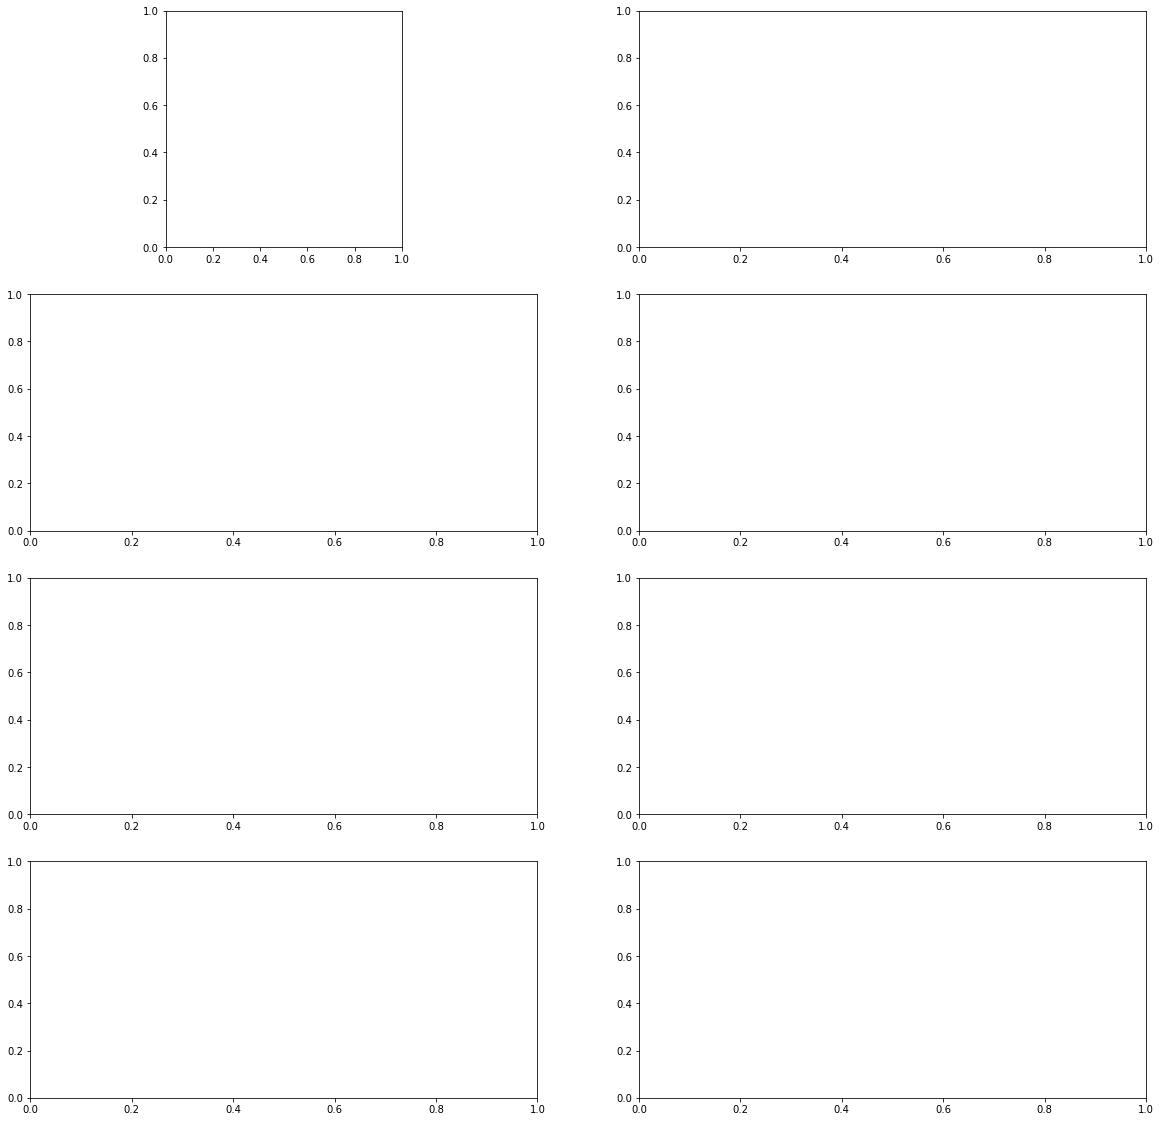

In [64]:
# plot 8 random photos of normal and pneumonia X-ray
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for x in range(0,4):
        i = np.random.randint(0,len(imgs_train))
        axes[x][0].imshow(imgs_train[i])
        axes[x][1].imshow(imgs_train_clean[i])

#         if train_labels[i][0] == 0:
#             axes[x][y].set_title('Normal')
#         else:
#             axes[x][y].set_title('Pneumonia')

Make new split directory

### Setting up help functions:

##### Results visualization:

In [20]:
# Plots of losses.
def visualize_training_results(results):
    # Create figures
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    # Loss functions plot
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    # Accuracy plot
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    path = "./img/Loss_"+model_name+".png"
    plt.savefig(path)
    plt.show()
    
    

In [21]:
# Create data with aug
def process_data_aug(img_size, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=20,   
                                       zoom_range=0.2,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2,
                                       vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_datagen.flow_from_directory(
      directory=train_folder, 
      target_size=img_size, 
      batch_size=92, 
      class_mode='binary',
      shuffle = True)

    val_generator = test_val_datagen.flow_from_directory(
      directory=val_folder, 
      target_size=img_size, 
      batch_size=32, 
      class_mode='binary',
      shuffle = True)
    
    test_generator = test_val_datagen.flow_from_directory(
        test_folder, 
        target_size=img_size, 
        batch_size = test_img_number)  
    
    
    return train_generator, val_generator, test_generator



In [22]:
# Create data without aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator



In [23]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    path = "./img/CM_"+model_name+".png"
    plt.savefig(path)
    plt.show()

In [24]:
# Plot results:
# - Loss, accuracy for val and train sets during training. 
# - Confusion matrix for test results. 

def plot_results(results, model, test_images,  test_y =None, threshold = 0.5,):
    visualize_training_results(results)
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    accuracy = accuracy_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    print('Test Accuracy = %.2f' % accuracy)# Combined plotting. 

    print('Recall = %.2f' % recall)
    confusion_mtx = confusion_matrix(test_y, predictions)
    cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

In [25]:
# Create dataframe with finall results.
result_columns = ["Model name","Image size","Parameters","Train time","Train accuracy", "Validation accuracy", "Test accuracy", "Test Recall"]
results_df = pd.DataFrame(columns = result_columns)

                  
# Results:
def make_results(model_selection, image_size, train_time,model_name, results, model, test_images, test_y, threshold = 0.5):
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_y, predictions),4)
    test_recall = round(recall_score(test_y, predictions),4)
    train_accuracy = round(results.history["accuracy"][-1],4)
    val_accuracy = round(results.history["val_accuracy"][-1],4)
    train_epoch = len(results.epoch)
    N_of_params = int(np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables]) + np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables]))
    line = pd.DataFrame(np.array([[model_name, image_size, N_of_params,
                               train_time, train_accuracy, val_accuracy,
                               test_accuracy, test_recall]]), columns = result_columns)
    model_selection = pd.concat([model_selection,line], axis = 0)
    return model_selection

### Use a densely connected network as a baseline

##### Prepare images

##### 64x64 images without data augmentation

In [26]:
image_size = (64,64)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)

Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
# Prepare images and lables.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [28]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4963
Number of testing samples: 624
Number of validation samples: 875
train_images shape: (4963, 64, 64, 3)
train_labels shape: (4963, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (875, 64, 64, 3)
val_labels shape: (875, 2)


##### Visualize data

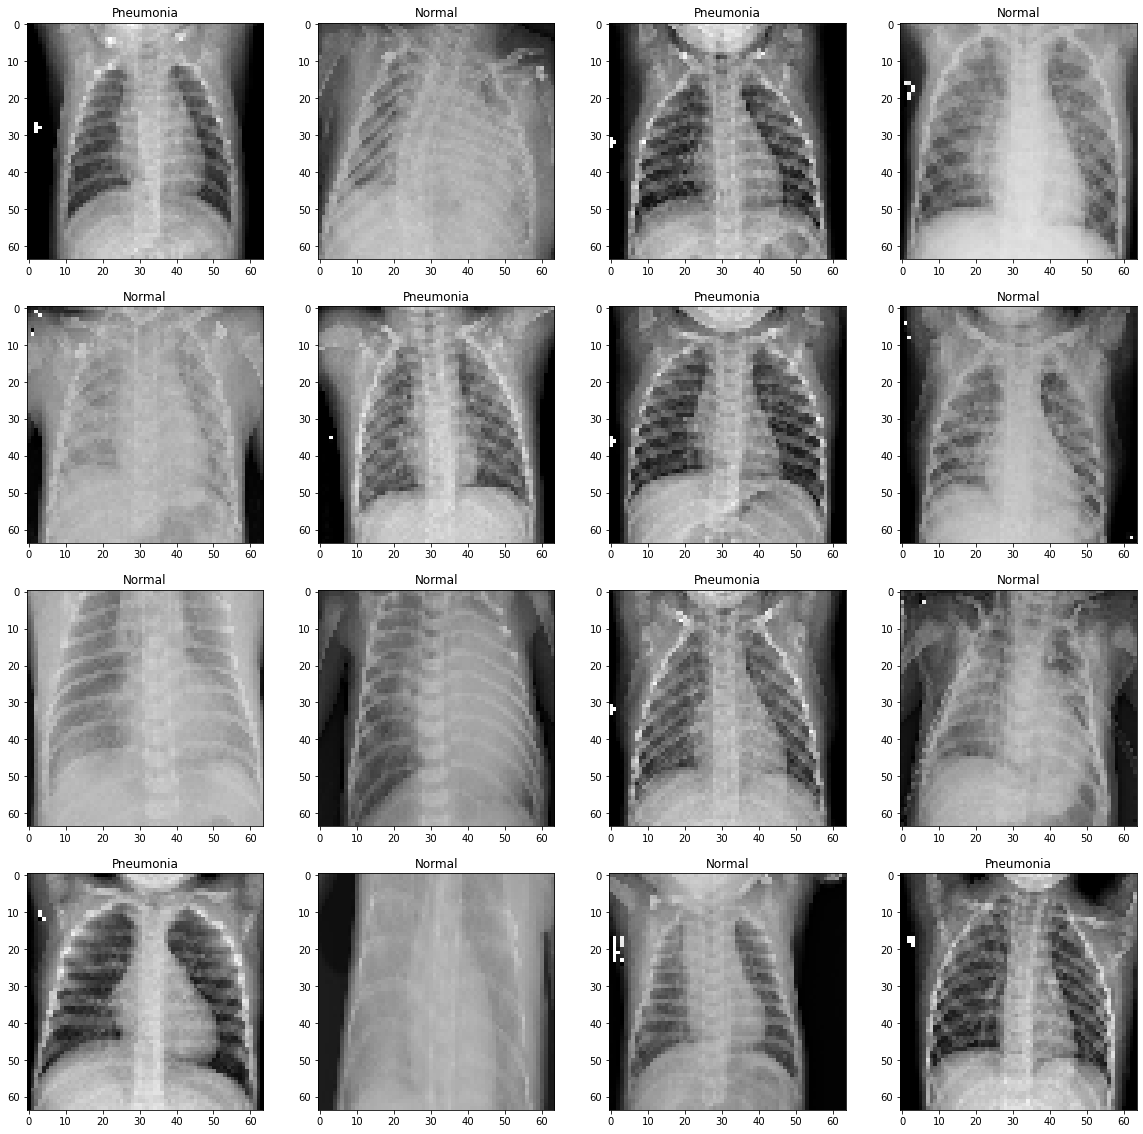

In [29]:
# plot 16 random photos of normal and pneumonia X-ray
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

for x in range(0,4):
    for y in range(0, 4):
        i = np.random.randint(0,len(train_images))
        axes[x][y].imshow(train_images[i])
        
        if train_labels[i][0] == 0:
            axes[x][y].set_title('Normal')
        else:
            axes[x][y].set_title('Pneumonia')

In [30]:
# Finall features set:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4963, 12288)
(624, 12288)
(875, 12288)


In [31]:
# Labels. 
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

##### 1) Prepare 1st Baseline mode.

In [32]:
# Initialize 1st mode.

np.random.seed(123)
model_name = "Baseline_model"
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-02-17 16:31:14.394427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Train model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model.save(savepath)

Epoch 1/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4490 - accuracy: 0.7925 - val_loss: 0.6565 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 1s 4ms/step - loss: 0.3278 - accuracy: 0.8672 - val_loss: 0.3731 - val_accuracy: 0.8331
Epoch 3/20
156/156 [==============================] - 1s 4ms/step - loss: 0.2489 - accuracy: 0.8993 - val_loss: 0.2532 - val_accuracy: 0.8891
Epoch 4/20
156/156 [==============================] - 1s 3ms/step - loss: 0.2073 - accuracy: 0.9176 - val_loss: 0.1726 - val_accuracy: 0.9303
Epoch 5/20
156/156 [==============================] - 1s 3ms/step - loss: 0.1718 - accuracy: 0.9333 - val_loss: 0.2375 - val_accuracy: 0.9017
Epoch 6/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1772 - accuracy: 0.9315 - val_loss: 0.2411 - val_accuracy: 0.9063
Epoch 7/20
156/156 [==============================] - 1s 3ms/step - loss: 0.1731 - accuracy: 0.9331 - val_loss: 2.3864 - val_accuracy: 0.2571
Epoch 

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915


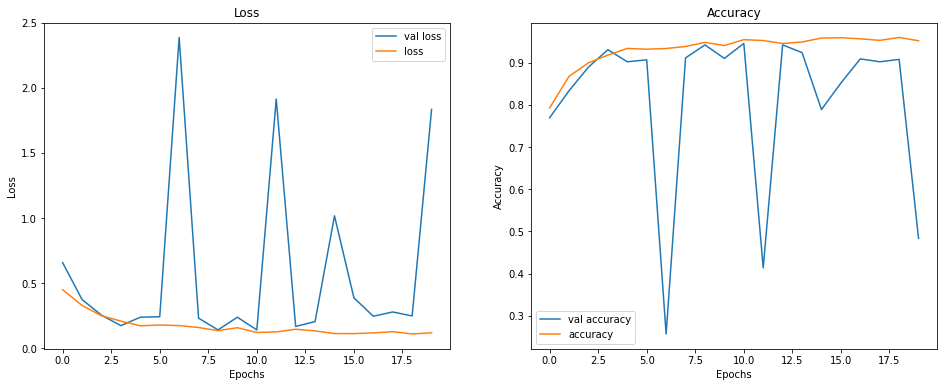

Test Accuracy = 0.63
Recall = 0.99


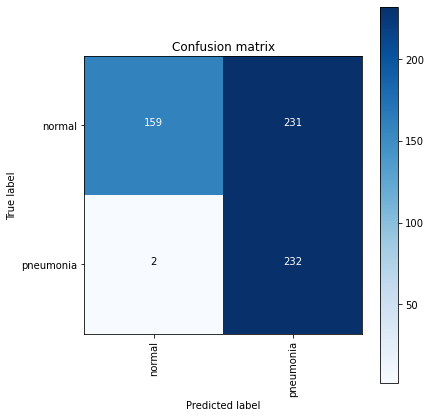

In [34]:
# process results

results_df = make_results(results_df,image_size,train_time,model_name,history_base, model, test_img, test_y)
display(results_df)
plot_results(history_base, model, test_img,  test_y,)

##### 2) Baseline model with regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [36]:
# Lets find the best L2 value.

In [37]:
L2_list = [0.001, 0.01, 0.1, 1]

In [38]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


20/20 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.6250


In [39]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

Best L2 regulization parameter: 0.1


In [40]:
# Model with regulization

In [41]:
model_name = "Baseline with reg"
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model2.save(savepath)



Epoch 1/20
156/156 [==============================] - 2s 10ms/step - loss: 11.4592 - accuracy: 0.7844 - val_loss: 8.3783 - val_accuracy: 0.8583
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 6.2976 - accuracy: 0.8598 - val_loss: 5.6212 - val_accuracy: 0.2331
Epoch 3/20
156/156 [==============================] - 1s 10ms/step - loss: 3.5703 - accuracy: 0.8829 - val_loss: 2.9642 - val_accuracy: 0.7166
Epoch 4/20
156/156 [==============================] - 2s 10ms/step - loss: 2.1085 - accuracy: 0.8918 - val_loss: 1.6550 - val_accuracy: 0.8640
Epoch 5/20
156/156 [==============================] - 1s 9ms/step - loss: 1.3245 - accuracy: 0.9019 - val_loss: 1.0763 - val_accuracy: 0.8869
Epoch 6/20
156/156 [==============================] - 1s 9ms/step - loss: 0.9149 - accuracy: 0.9011 - val_loss: 1.8619 - val_accuracy: 0.2320
Epoch 7/20
156/156 [==============================] - 1s 9ms/step - loss: 0.6948 - accuracy: 0.8966 - val_loss: 1.2602 - val_accuracy: 0.4400
Ep

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0


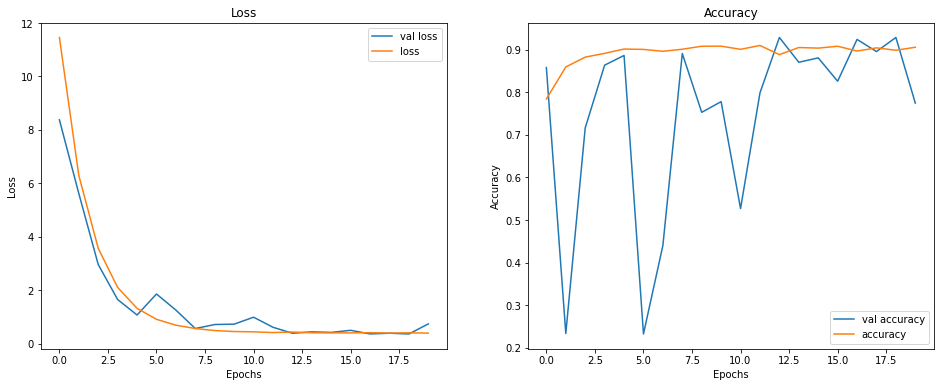

Test Accuracy = 0.62
Recall = 0.00


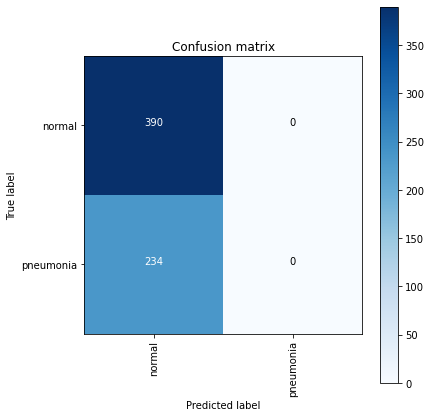

In [42]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model2, model2, test_img, test_y)
display(results_df)
plot_results(history_model2, model2, test_img, test_y)

In [43]:
# model overfit

##### 3) Baseline model with regulization and Dropout

In [44]:
model_name = "Baseline with reg, dropout"
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [45]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model3.save(savepath)


Epoch 1/20
156/156 [==============================] - 3s 12ms/step - loss: 8.4594 - accuracy: 0.7504 - val_loss: 6.3135 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 2s 10ms/step - loss: 4.9113 - accuracy: 0.7687 - val_loss: 3.7194 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 2s 10ms/step - loss: 2.9961 - accuracy: 0.7691 - val_loss: 2.3579 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 2s 10ms/step - loss: 1.9830 - accuracy: 0.7689 - val_loss: 1.7261 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 1s 10ms/step - loss: 1.4232 - accuracy: 0.7689 - val_loss: 1.1798 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 2s 10ms/step - loss: 1.1280 - accuracy: 0.7689 - val_loss: 0.9916 - val_accuracy: 0.7691
Epoch 7/20
156/156 [==============================] - 2s 10ms/step - loss: 0.9855 - accuracy: 0.7689 - val_loss: 0.9208 - val_accuracy: 0.7691

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0


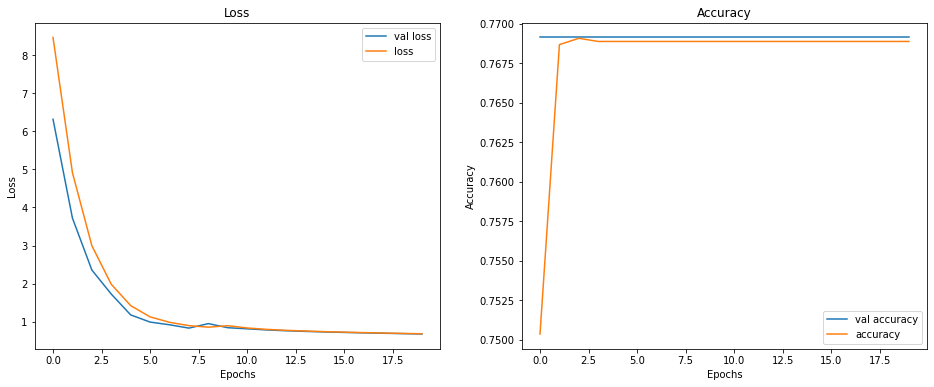

Test Accuracy = 0.62
Recall = 0.00


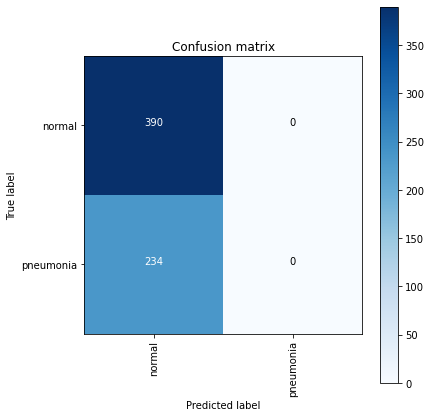

In [46]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model3, model3, test_img, test_y)
display(results_df)
plot_results(history_model3, model3, test_img, test_y)

In [47]:
# model overfit

##### 4) Baseline model with regulization and Dropout. Changed  optimizer to Adam

In [48]:
model_name = "Baseline with reg, dropout, optimizer"

model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model4.save(savepath)

Epoch 1/20
156/156 [==============================] - 5s 14ms/step - loss: 2.9745 - accuracy: 0.6935 - val_loss: 1.4914 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 2s 12ms/step - loss: 1.2326 - accuracy: 0.7512 - val_loss: 0.9703 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 2s 13ms/step - loss: 0.8973 - accuracy: 0.7645 - val_loss: 0.7719 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 2s 12ms/step - loss: 0.7255 - accuracy: 0.7683 - val_loss: 0.6703 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 2s 14ms/step - loss: 0.6555 - accuracy: 0.7689 - val_loss: 0.6310 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 2s 15ms/step - loss: 0.6138 - accuracy: 0.7689 - val_loss: 0.5978 - val_accuracy: 0.7691
Epoch 7/20
156/156 [==============================] - 2s 13ms/step - loss: 0.5919 - accuracy: 0.7689 - val_loss: 0.5858 - val_accuracy: 0.7691

In [50]:
results_train4 = model4.evaluate(train_img, train_y)

156/156 [==============================] - 1s 5ms/step - loss: 0.5412 - accuracy: 0.7689


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0


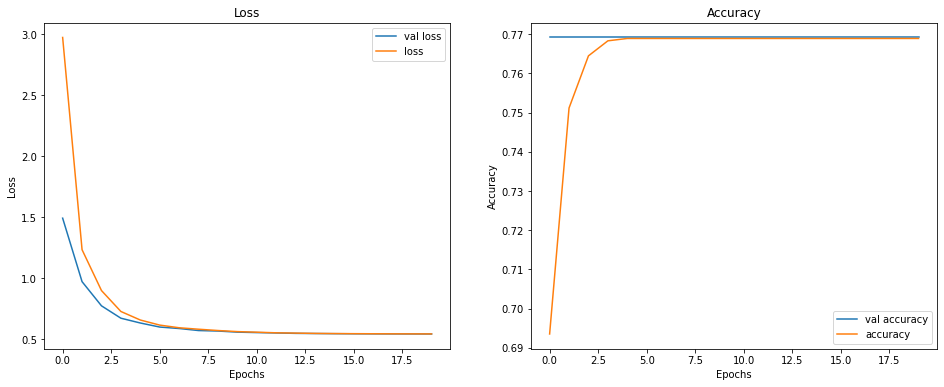

Test Accuracy = 0.62
Recall = 0.00


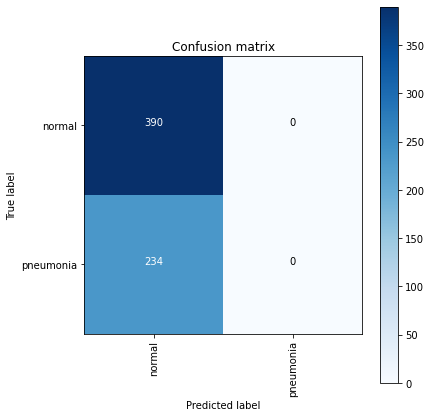

In [51]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model4, model4, test_img, test_y)
display(results_df)
plot_results(history_model4, model4, test_img, test_y)

In [52]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

20/20 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.6250
Test set results accuracy 0.625


In [53]:
# Model has serious overfitting issues. 

##### 5) Baseline + regulization + Dropout + Adam optimizer + increased train time

In [54]:
model_name = "Baseline with reg, dropout, optimizer + extra train time"

model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [55]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model5.save(savepath)

Epoch 1/50
100/100 [==============================] - 2s 14ms/step - loss: 1.2671 - accuracy: 0.7467 - val_loss: 0.8628 - val_accuracy: 0.7691
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 0.7435 - accuracy: 0.7679 - val_loss: 0.6239 - val_accuracy: 0.7691
Epoch 3/50
100/100 [==============================] - 1s 14ms/step - loss: 0.6125 - accuracy: 0.7689 - val_loss: 0.4924 - val_accuracy: 0.7691
Epoch 4/50
100/100 [==============================] - 1s 14ms/step - loss: 0.5548 - accuracy: 0.7695 - val_loss: 0.5421 - val_accuracy: 0.7691
Epoch 5/50
100/100 [==============================] - 1s 15ms/step - loss: 0.5765 - accuracy: 0.7681 - val_loss: 0.6541 - val_accuracy: 0.7691
Epoch 6/50
100/100 [==============================] - 1s 14ms/step - loss: 0.5657 - accuracy: 0.7689 - val_loss: 0.4437 - val_accuracy: 0.7691
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - loss: 0.5213 - accuracy: 0.7689 - val_loss: 0.5261 - val_accuracy: 0.7691

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0


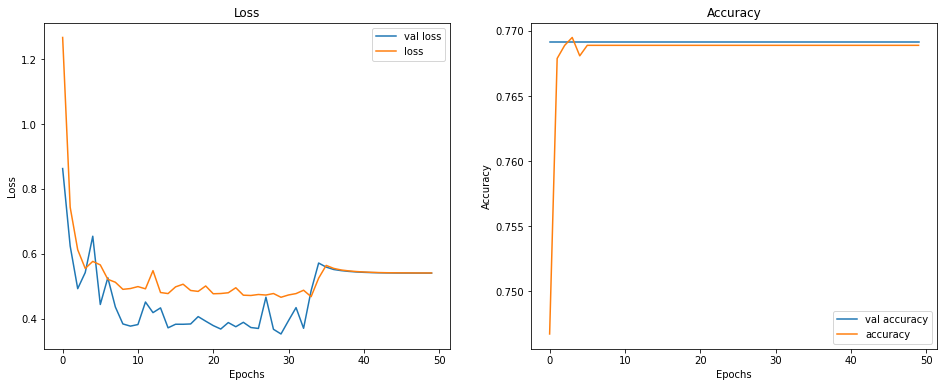

Test Accuracy = 0.62
Recall = 0.00


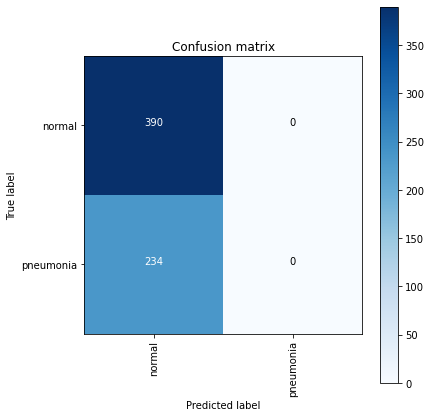

In [56]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model5, model5, test_img, test_y)
display(results_df)
plot_results(history_model5, model5, test_img, test_y)

In [57]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

20/20 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.6250
Test set results accuracy 0.625


In [58]:
# Model has serious overfitting issues. 

##### 6) Basic CNN model, image shape 64x64

In [59]:
model_name = "Basic CNN"

model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(16, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [60]:
start = time.time()
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN.save(savepath)

Epoch 1/15
156/156 [==============================] - 32s 198ms/step - loss: 0.5510 - accuracy: 0.7606 - val_loss: 0.5311 - val_accuracy: 0.7691
Epoch 2/15
156/156 [==============================] - 31s 201ms/step - loss: 0.4984 - accuracy: 0.7691 - val_loss: 0.5225 - val_accuracy: 0.7691
Epoch 3/15
156/156 [==============================] - 32s 206ms/step - loss: 0.4034 - accuracy: 0.8128 - val_loss: 0.5286 - val_accuracy: 0.7691
Epoch 4/15
156/156 [==============================] - 32s 205ms/step - loss: 0.2887 - accuracy: 0.8789 - val_loss: 0.5087 - val_accuracy: 0.7749
Epoch 5/15
156/156 [==============================] - 31s 199ms/step - loss: 0.2255 - accuracy: 0.9101 - val_loss: 0.2495 - val_accuracy: 0.8846
Epoch 6/15
156/156 [==============================] - 29s 185ms/step - loss: 0.1824 - accuracy: 0.9291 - val_loss: 0.1662 - val_accuracy: 0.9234
Epoch 7/15
156/156 [==============================] - 30s 192ms/step - loss: 0.1593 - accuracy: 0.9359 - val_loss: 0.6165 - val_ac

In [61]:
results_test = model_CNN.evaluate(test_images, test_y)

20/20 [==============================] - 1s 40ms/step - loss: 0.6950 - accuracy: 0.7837


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444


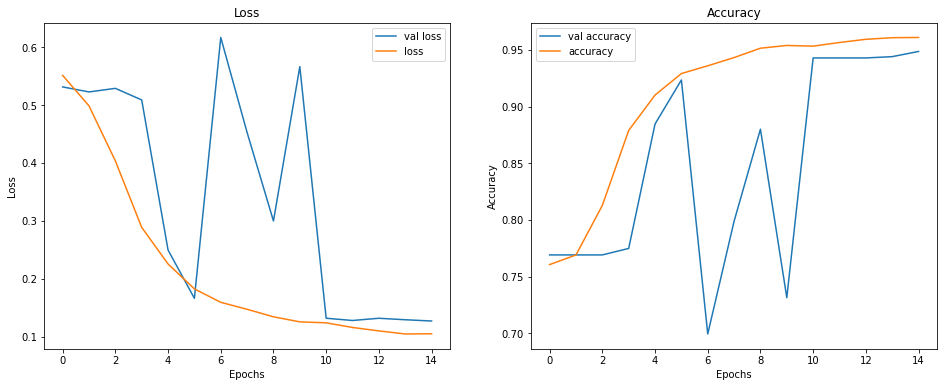

Test Accuracy = 0.78
Recall = 0.44


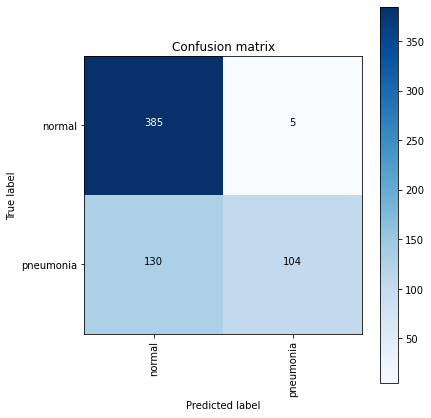

In [62]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN1, model_CNN, test_images, test_y)
display(results_df)
plot_results(history_CNN1, model_CNN, test_images, test_y)

##### 7) Basic CNN, shape 64 x 64 with regulization

In [63]:
model_name = "Basic CNN with reg, dropout"

model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [64]:
start = time.time()
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/15
156/156 [==============================] - 27s 165ms/step - loss: 0.7068 - accuracy: 0.8489 - val_loss: 0.5429 - val_accuracy: 0.8114
Epoch 2/15
156/156 [==============================] - 22s 139ms/step - loss: 0.2467 - accuracy: 0.9246 - val_loss: 0.2117 - val_accuracy: 0.9349
Epoch 3/15
156/156 [==============================] - 20s 126ms/step - loss: 0.2042 - accuracy: 0.9375 - val_loss: 0.2247 - val_accuracy: 0.9417
Epoch 4/15
156/156 [==============================] - 19s 124ms/step - loss: 0.1898 - accuracy: 0.9456 - val_loss: 0.1677 - val_accuracy: 0.9486
Epoch 5/15
156/156 [==============================] - 19s 123ms/step - loss: 0.1716 - accuracy: 0.9484 - val_loss: 0.1914 - val_accuracy: 0.9394
Epoch 6/15
156/156 [==============================] - 19s 122ms/step - loss: 0.1713 - accuracy: 0.9510 - val_loss: 0.1583 - val_accuracy: 0.9486
Epoch 7/15
156/156 [==============================] - 19s 123ms/step - loss: 0.1470 - accuracy: 0.9595 - val_loss: 0.1704 - val_ac

In [65]:
results_test = model_CNN2.evaluate(test_images, test_y)

20/20 [==============================] - 0s 21ms/step - loss: 1.5863 - accuracy: 0.6763


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368


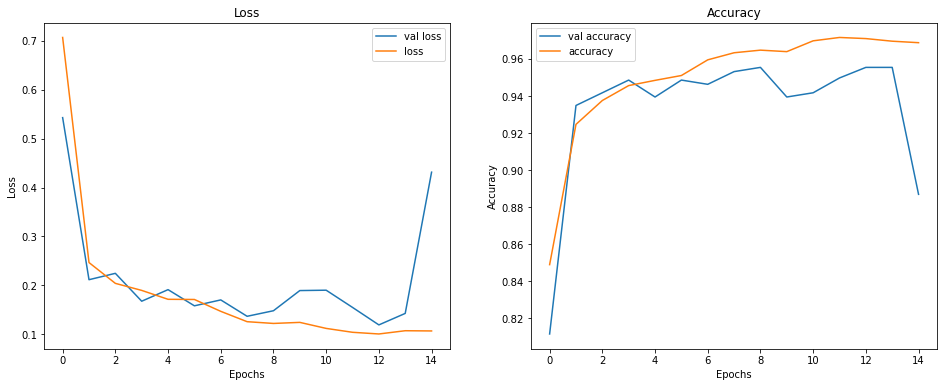

Test Accuracy = 0.68
Recall = 0.14


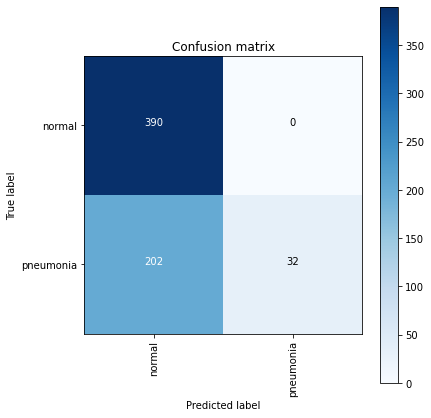

In [66]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN2, model_CNN2, test_images, test_y)
display(results_df)
plot_results(history_CNN2, model_CNN2, test_images, test_y)

##### 7) Basic CNN, shape 100 x 100

In [67]:

# Reshape images to 100x100

image_size = (100,100)
train_generator_100, val_generator_100, test_generator_100 = process_data_no_aug(image_size)

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)




Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [68]:
# Reshape images
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

# Check the shape after. 
print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

(4963, 30000)
(624, 30000)
(875, 30000)


In [69]:
# Labels
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [70]:
# Create model.
model_name = "Basic CNN 100x100"

model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(16, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [71]:
start = time.time()

history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=10,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN3.save(savepath)


Epoch 1/15
100/100 [==============================] - 34s 329ms/step - loss: 0.5470 - accuracy: 0.7689 - val_loss: 0.5472 - val_accuracy: 0.7691
Epoch 2/15
100/100 [==============================] - 39s 391ms/step - loss: 0.5425 - accuracy: 0.7689 - val_loss: 0.5433 - val_accuracy: 0.7691
Epoch 3/15
100/100 [==============================] - 41s 411ms/step - loss: 0.5425 - accuracy: 0.7689 - val_loss: 0.5496 - val_accuracy: 0.7691
Epoch 4/15
100/100 [==============================] - 44s 439ms/step - loss: 0.5424 - accuracy: 0.7689 - val_loss: 0.5424 - val_accuracy: 0.7691
Epoch 5/15
100/100 [==============================] - 44s 437ms/step - loss: 0.5420 - accuracy: 0.7689 - val_loss: 0.5425 - val_accuracy: 0.7691
Epoch 6/15
100/100 [==============================] - 45s 452ms/step - loss: 0.5410 - accuracy: 0.7689 - val_loss: 0.5454 - val_accuracy: 0.7691
Epoch 7/15
100/100 [==============================] - 42s 424ms/step - loss: 0.5421 - accuracy: 0.7689 - val_loss: 0.5476 - val_ac

In [72]:
results_test = model_CNN3.evaluate(test_images2, test_y2)

20/20 [==============================] - 1s 54ms/step - loss: 0.7268 - accuracy: 0.6250


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0


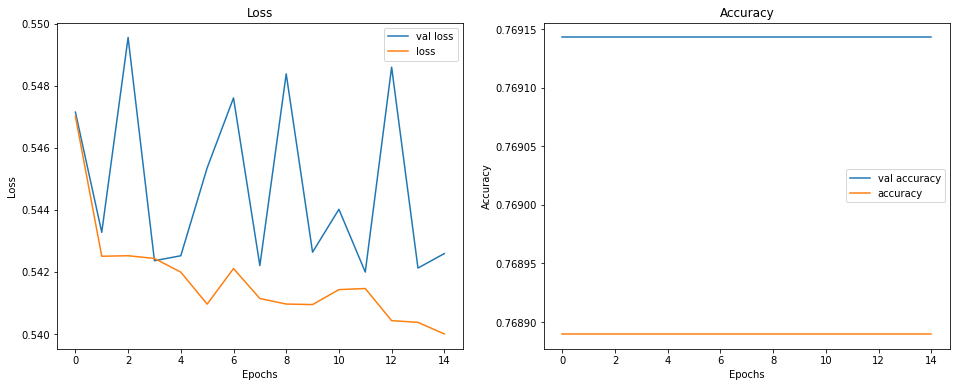

Test Accuracy = 0.62
Recall = 0.00


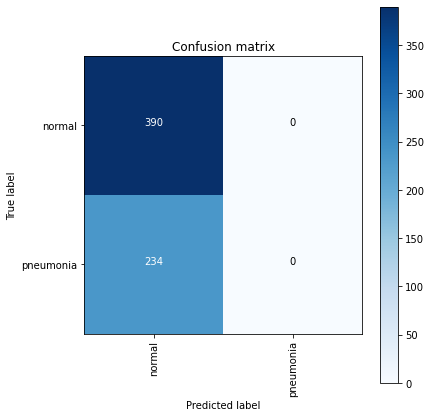

In [73]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN3, model_CNN3, test_images2, test_y2)
display(results_df)
plot_results(history_CNN3, model_CNN3, test_images2, test_y2)

##### 8) Basic CNN, shape 100 x 100 with regulization and dropout

In [74]:
model_name = "Basic CNN 100x100 with reg and dropout"

model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN4.add(layers.Dropout(0.3))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [75]:
start = time.time()

history_CNN4 = model_CNN4.fit(train_images2,
                    train_y2,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN4.save(savepath)

Epoch 1/15
156/156 [==============================] - 50s 318ms/step - loss: 0.8767 - accuracy: 0.7653 - val_loss: 0.8446 - val_accuracy: 0.7691
Epoch 2/15
156/156 [==============================] - 50s 323ms/step - loss: 0.8481 - accuracy: 0.7689 - val_loss: 0.8238 - val_accuracy: 0.7691
Epoch 3/15
156/156 [==============================] - 49s 317ms/step - loss: 0.8238 - accuracy: 0.7689 - val_loss: 0.8085 - val_accuracy: 0.7691
Epoch 4/15
156/156 [==============================] - 49s 317ms/step - loss: 0.8135 - accuracy: 0.7689 - val_loss: 0.7987 - val_accuracy: 0.7691
Epoch 5/15
156/156 [==============================] - 50s 320ms/step - loss: 0.7915 - accuracy: 0.7689 - val_loss: 0.7755 - val_accuracy: 0.7691
Epoch 6/15
156/156 [==============================] - 51s 325ms/step - loss: 0.7767 - accuracy: 0.7689 - val_loss: 0.7615 - val_accuracy: 0.7691
Epoch 7/15
156/156 [==============================] - 50s 323ms/step - loss: 0.7601 - accuracy: 0.7689 - val_loss: 0.7683 - val_ac

In [76]:
results_test = model_CNN4.evaluate(test_images2, test_y2)

20/20 [==============================] - 2s 80ms/step - loss: 0.8134 - accuracy: 0.6250


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0


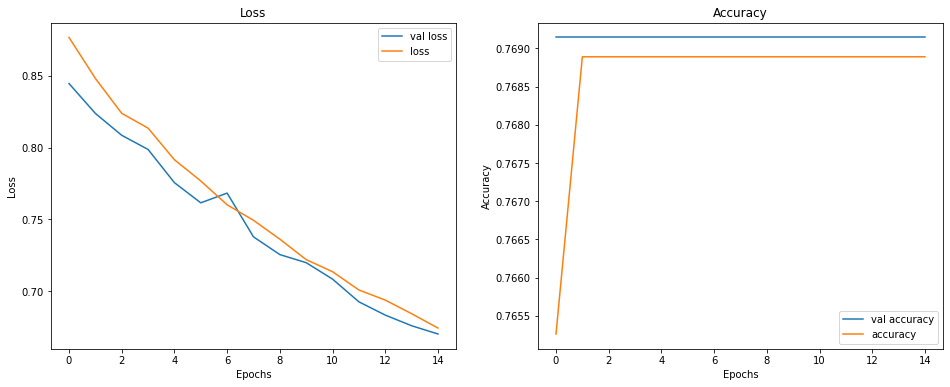

Test Accuracy = 0.62
Recall = 0.00


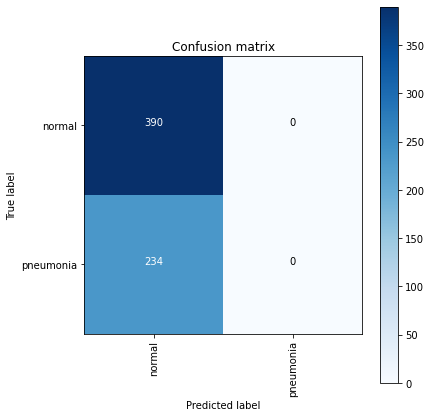

In [77]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN4, model_CNN4, test_images2, test_y2)
display(results_df)
plot_results(history_CNN4, model_CNN4, test_images2, test_y2)

##### Change data

In [78]:
image_size = (100,100)
batch_size = 120
train_generator_arg_100, val_generator_arg_100, test_generator_arg_100 = process_data_aug(image_size, batch_size)


Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [80]:
train_images_100_arg, train_labels_100_arg = next(train_generator_arg_100)
test_images_100_arg, test_labels_100_arg = next(test_generator_arg_100)
val_images_100_arg, val_labels_100_arg = next(val_generator_arg_100)

#test_y = np.reshape(test_labels_100_arg[:,], (test_img_number,1))

##### 9) Augment CNN, shape 100 x 100 with regularization

In [81]:
model_name = "Augmented CNN 100x100 with reg"

model_CNN6 = models.Sequential()
model_CNN6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))
model_CNN6.add(layers.Dropout(0.2))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Flatten())
model_CNN6.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.Dropout(0.3))
model_CNN6.add(layers.Dense(1, activation='sigmoid'))



model_CNN6.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [82]:
start = time.time()
history_CNN6 = model_CNN6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=15, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN6.save(savepath)

Epoch 1/15
25/25 [==============================] - 95s 4s/step - loss: 1.0702 - accuracy: 0.7630 - val_loss: 0.7612 - val_accuracy: 0.7675
Epoch 2/15
25/25 [==============================] - 93s 4s/step - loss: 0.6411 - accuracy: 0.7717 - val_loss: 0.6259 - val_accuracy: 0.7700
Epoch 3/15
25/25 [==============================] - 88s 4s/step - loss: 0.5516 - accuracy: 0.7770 - val_loss: 0.5237 - val_accuracy: 0.7650
Epoch 4/15
25/25 [==============================] - 89s 4s/step - loss: 0.4922 - accuracy: 0.7625 - val_loss: 0.5062 - val_accuracy: 0.7713
Epoch 5/15
25/25 [==============================] - 89s 4s/step - loss: 0.4634 - accuracy: 0.7678 - val_loss: 0.4232 - val_accuracy: 0.8112
Epoch 6/15
25/25 [==============================] - 87s 4s/step - loss: 0.3891 - accuracy: 0.8157 - val_loss: 0.4123 - val_accuracy: 0.8612
Epoch 7/15
25/25 [==============================] - 91s 4s/step - loss: 0.4338 - accuracy: 0.8083 - val_loss: 0.4723 - val_accuracy: 0.8575
Epoch 8/15
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


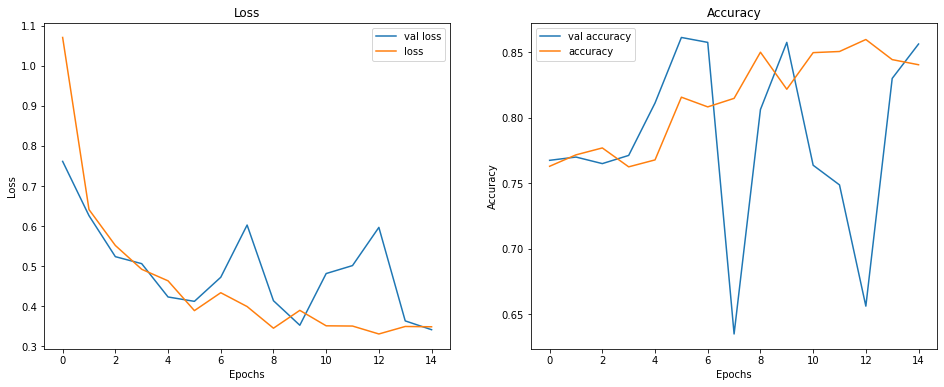

Test Accuracy = 0.50
Recall = 0.63


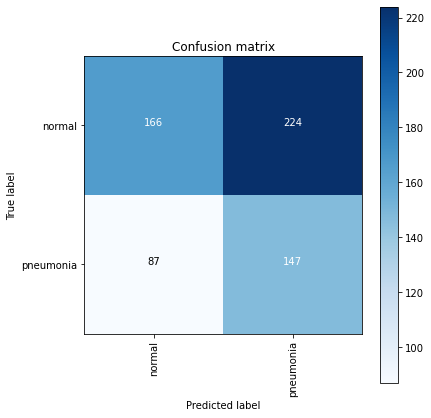

In [83]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN6, model_CNN6, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN6, model_CNN6, test_images_100_arg, test_y)

argumented CNN 100 batch 64/32 Rmsprop

##### 10) Augment CNN, shape 100 x 100 with reg and RMSprop optimizer

In [84]:
model_name = "Augmented CNN 100x100 with reg and RMSprop optimizer"

model_CNN8 = models.Sequential()
model_CNN8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Flatten())
model_CNN8.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.Dropout(0.3))
model_CNN8.add(layers.Dense(1, activation='sigmoid'))

model_CNN8.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])


In [85]:
start = time.time()

history_CNN8 = model_CNN8.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN8.save(savepath)

Epoch 1/10
25/25 [==============================] - 94s 4s/step - loss: 1.1357 - accuracy: 0.7287 - val_loss: 0.7497 - val_accuracy: 0.7725
Epoch 2/10
25/25 [==============================] - 93s 4s/step - loss: 0.6758 - accuracy: 0.7743 - val_loss: 0.6309 - val_accuracy: 0.7650
Epoch 3/10
25/25 [==============================] - 93s 4s/step - loss: 0.6017 - accuracy: 0.7726 - val_loss: 0.5723 - val_accuracy: 0.7700
Epoch 4/10
25/25 [==============================] - 93s 4s/step - loss: 0.5683 - accuracy: 0.7699 - val_loss: 0.5426 - val_accuracy: 0.7763
Epoch 5/10
25/25 [==============================] - 91s 4s/step - loss: 0.5369 - accuracy: 0.7778 - val_loss: 0.6783 - val_accuracy: 0.7688
Epoch 6/10
25/25 [==============================] - 92s 4s/step - loss: 0.5431 - accuracy: 0.7621 - val_loss: 0.5266 - val_accuracy: 0.7713
Epoch 7/10
25/25 [==============================] - 91s 4s/step - loss: 0.5211 - accuracy: 0.7686 - val_loss: 0.5393 - val_accuracy: 0.7663
Epoch 8/10
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


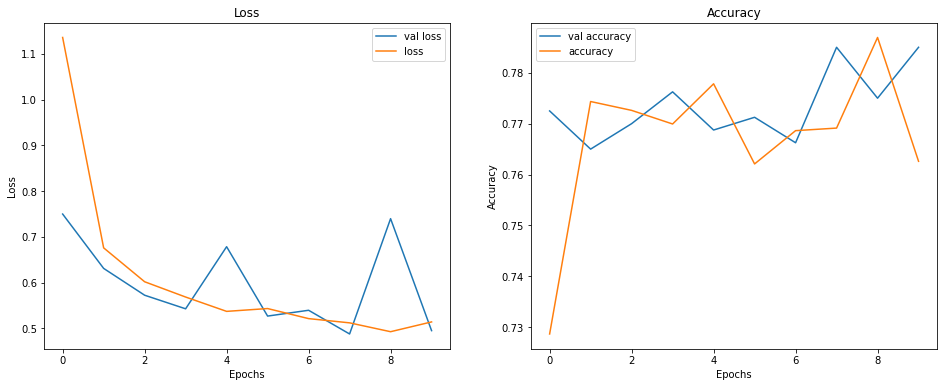

Test Accuracy = 0.38
Recall = 0.97


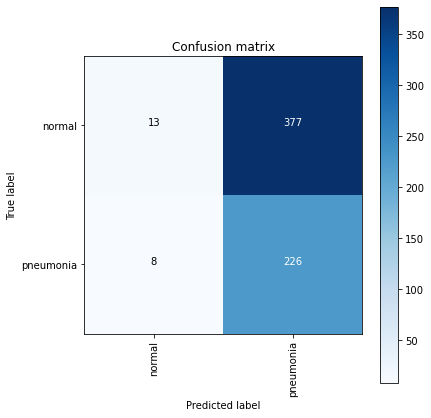

In [86]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN8, model_CNN8, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN8, model_CNN8, test_images_100_arg, test_y)

In [87]:
results_test = model_CNN8.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 1s 63ms/step - loss: 1.2332 - accuracy: 0.3830


##### 11) Augment CNN, shape 100 x 100 with reg with additional regularizer

In [88]:
model_name = "Augmented CNN 100x100 with additional reg, increased training time"
model_CNN9 = models.Sequential()
model_CNN9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Flatten())
model_CNN9.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN9.add(layers.Dropout(0.3))
model_CNN9.add(layers.Dense(1, activation='sigmoid'))

model_CNN9.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [89]:
start = time.time()
history_CNN9 = model_CNN9.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=30, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN9.save(savepath)

Epoch 1/30
25/25 [==============================] - 94s 4s/step - loss: 1.0343 - accuracy: 0.7670 - val_loss: 0.7193 - val_accuracy: 0.7713
Epoch 2/30
25/25 [==============================] - 94s 4s/step - loss: 0.6596 - accuracy: 0.7661 - val_loss: 0.6089 - val_accuracy: 0.7725
Epoch 3/30
25/25 [==============================] - 92s 4s/step - loss: 0.5554 - accuracy: 0.7635 - val_loss: 0.5627 - val_accuracy: 0.7663
Epoch 4/30
25/25 [==============================] - 89s 4s/step - loss: 0.5153 - accuracy: 0.7661 - val_loss: 0.6335 - val_accuracy: 0.7675
Epoch 5/30
25/25 [==============================] - 92s 4s/step - loss: 0.5155 - accuracy: 0.7635 - val_loss: 0.4933 - val_accuracy: 0.7887
Epoch 6/30
25/25 [==============================] - 91s 4s/step - loss: 0.4731 - accuracy: 0.7852 - val_loss: 0.5082 - val_accuracy: 0.7713
Epoch 7/30
25/25 [==============================] - 91s 4s/step - loss: 0.4551 - accuracy: 0.7857 - val_loss: 0.4719 - val_accuracy: 0.8163
Epoch 8/30
25/25 [==

In [90]:
results_test = model_CNN9.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 2s 80ms/step - loss: 1.6937 - accuracy: 0.4615


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


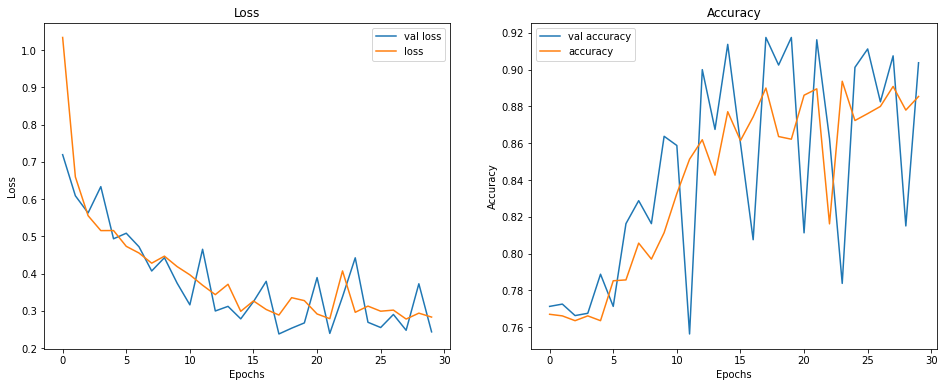

Test Accuracy = 0.46
Recall = 0.69


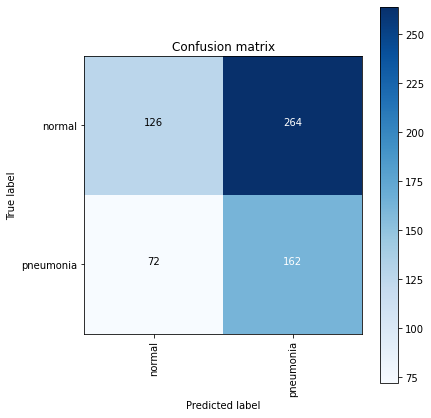

In [91]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN9, model_CNN9, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN9, model_CNN9, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16

In [92]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16, batch 92"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new7 = models.Sequential()
model_new7.add(base_model_cnn)
model_new7.add(layers.Flatten())
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(1,activation="sigmoid"))
model_new7.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new7 = model_new7.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new7.save(savepath)

Epoch 1/10
25/25 [==============================] - 162s 6s/step - loss: 1.1262 - accuracy: 0.7978 - val_loss: 0.6076 - val_accuracy: 0.9112
Epoch 2/10
25/25 [==============================] - 156s 6s/step - loss: 0.5269 - accuracy: 0.8723 - val_loss: 0.4343 - val_accuracy: 0.9100
Epoch 3/10
25/25 [==============================] - 150s 6s/step - loss: 0.4368 - accuracy: 0.8763 - val_loss: 0.3507 - val_accuracy: 0.9175
Epoch 4/10
25/25 [==============================] - 144s 6s/step - loss: 0.3970 - accuracy: 0.8828 - val_loss: 0.3138 - val_accuracy: 0.9337
Epoch 5/10
25/25 [==============================] - 145s 6s/step - loss: 0.3792 - accuracy: 0.8865 - val_loss: 0.3626 - val_accuracy: 0.8925
Epoch 6/10
25/25 [==============================] - 148s 6s/step - loss: 0.3738 - accuracy: 0.8885 - val_loss: 0.2721 - val_accuracy: 0.9463
Epoch 7/10
25/25 [==============================] - 142s 6s/step - loss: 0.3641 - accuracy: 0.8749 - val_loss: 0.4174 - val_accuracy: 0.8475
Epoch 8/10
25

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


FileNotFoundError: [Errno 2] No such file or directory: './img/Loss_Pre-trained Augmented CNN 100x100 frozen layer VGG16, batch 92/32.png'

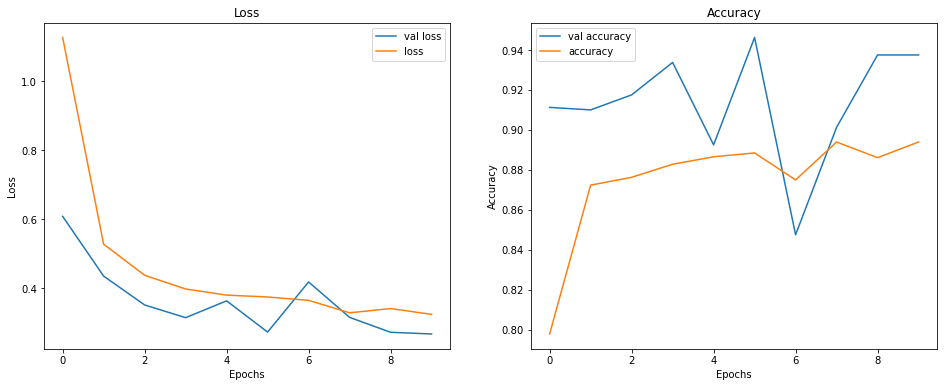

In [93]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new7, model_new7, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new7, model_new7, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16 batch 64/32

In [94]:
image_size = (100,100)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 24,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


##### 13) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

In [95]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16 with weights"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new4 = models.Sequential()
model_new4.add(base_model_cnn)
model_new4.add(layers.Flatten())
model_new4.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new4.add(layers.Dropout(0.3))
model_new4.add(layers.Dense(1,activation="sigmoid"))
model_new4.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new4 = model_new4.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25, class_weight = {0: 2, 1: 1})
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new4.save(savepath)

Epoch 1/10
25/25 [==============================] - 107s 4s/step - loss: 1.2813 - accuracy: 0.8160 - val_loss: 0.8310 - val_accuracy: 0.7833
Epoch 2/10
25/25 [==============================] - 106s 4s/step - loss: 0.6467 - accuracy: 0.8869 - val_loss: 0.5228 - val_accuracy: 0.8783
Epoch 3/10
25/25 [==============================] - 113s 5s/step - loss: 0.5137 - accuracy: 0.9083 - val_loss: 0.5510 - val_accuracy: 0.8400
Epoch 4/10
25/25 [==============================] - 112s 4s/step - loss: 0.4595 - accuracy: 0.9119 - val_loss: 0.3783 - val_accuracy: 0.9033
Epoch 5/10
25/25 [==============================] - 111s 4s/step - loss: 0.4776 - accuracy: 0.8988 - val_loss: 0.3544 - val_accuracy: 0.9183
Epoch 6/10
25/25 [==============================] - 109s 4s/step - loss: 0.4497 - accuracy: 0.9038 - val_loss: 0.3714 - val_accuracy: 0.8950
Epoch 7/10
25/25 [==============================] - 107s 4s/step - loss: 0.3767 - accuracy: 0.9262 - val_loss: 0.3052 - val_accuracy: 0.9300
Epoch 8/10
25

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


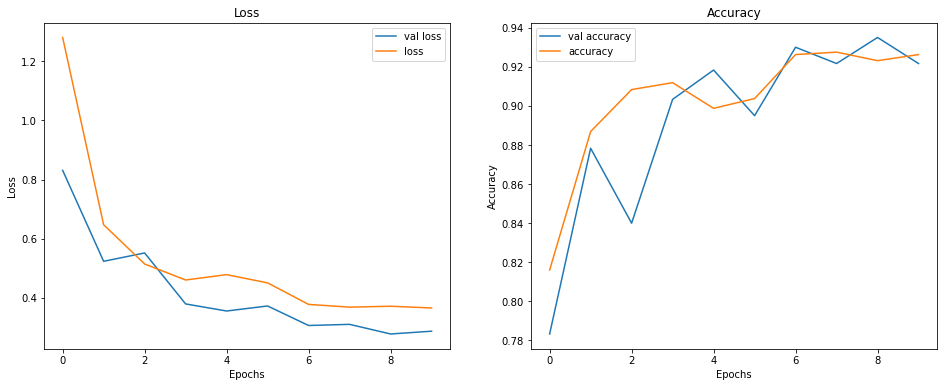

Test Accuracy = 0.54
Recall = 0.67


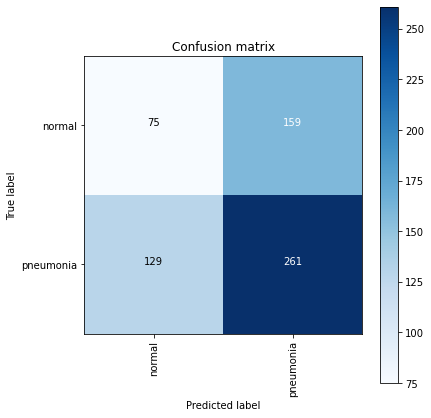

In [96]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new4, model_new4, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new4, model_new4, test_images_100_arg, test_y)

##### 14) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 89s 3s/step - loss: 1.1323 - accuracy: 0.7781 - val_loss: 0.5896 - val_accuracy: 0.9000
Epoch 2/10
25/25 [==============================] - 101s 4s/step - loss: 0.5210 - accuracy: 0.8656 - val_loss: 0.3643 - val_accuracy: 0.9560
Epoch 3/10
25/25 [==============================] - 103s 4s/step - loss: 0.4010 - accuracy: 0.8869 - val_loss: 0.3258 - val_accuracy: 0.9320
Epoch 4/10
25/25 [==============================] - 94s 4s/step - loss: 0.3407 - accuracy: 0.9069 - val_loss: 0.3089 - val_accuracy: 0.9320
Epoch 5/10
25/25 [==============================] - 95s 4s/step - loss: 0.3379 - accuracy: 0.9050 - val_loss: 0.2526 - val_accuracy: 0.9440
Epoch 6/10
25/25 [==============================] - 100s 4s/step - loss: 0.3067 - accuracy: 0.9100 - val_loss: 0.2526 - val_accuracy: 0.9400
Epoch 7/10
25/25 [===============

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


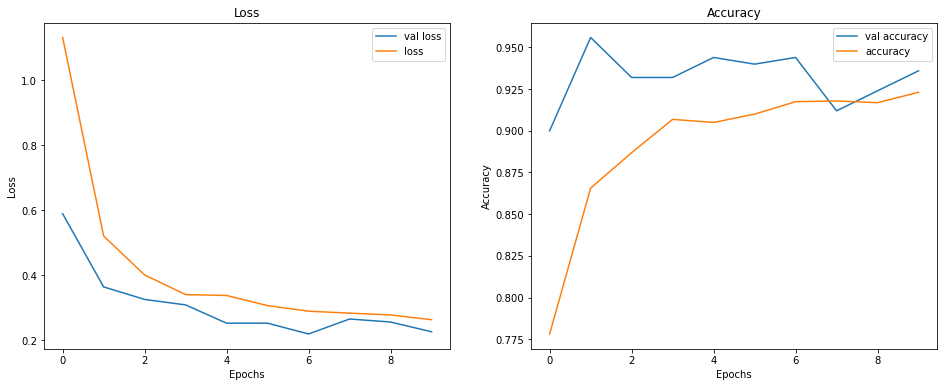

Test Accuracy = 0.83
Recall = 0.98


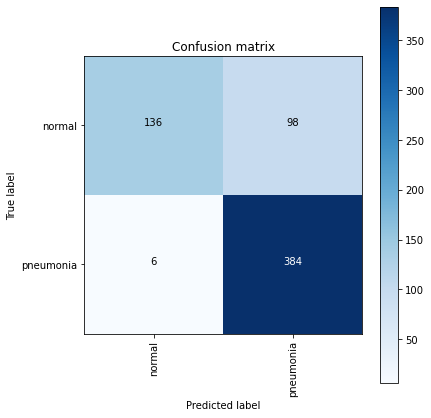

In [97]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(100, 100),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 15) Pre-trained Augmented CNN 224x224 with MobileNetV2. 

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/14
25/25 [==============================] - 104s 4s/step - loss: 1.8020 - accuracy: 0.8625 - val_loss: 1.1861 - val_accuracy: 0.9000
Epoch 2/14
25/25 [==============================] - 94s 4s/step - loss: 0.9888 - accuracy: 0.9237 - val_loss: 0.8618 - val_accuracy: 0.9080
Epoch 3/14
25/25 [==============================] - 106s 4s/step - loss: 0.7258 - accuracy: 0.9388 - val_loss: 0.6572 - val_accuracy: 0.9240
Epoch 4/14
25/25 [==============================] - 97s 4s/step - loss: 0.5747 - accuracy: 0.9375 - val_loss: 0.5129 - val_accuracy: 0.9600
Epoch 5/14
25/25 [==============================] - 93s 4s/step - loss: 0.5227 - accuracy: 0.9281 - val_loss: 0.4510 - val_accuracy: 0.9560
Epoch 6/14
25/25 [==============================] - 91s 4s/step - loss: 0.4197 - accuracy: 0.9481 - val_loss: 0.4018 - val_accuracy: 0.9360
Epoch 7/14
25/25 [================

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


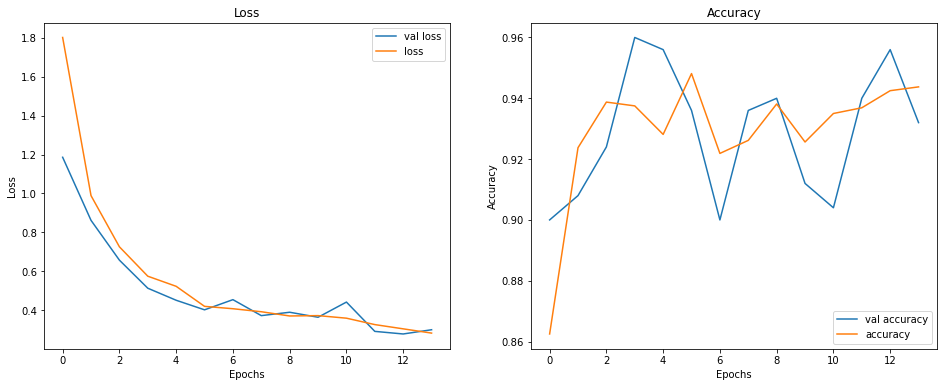

Test Accuracy = 0.95
Recall = 0.96


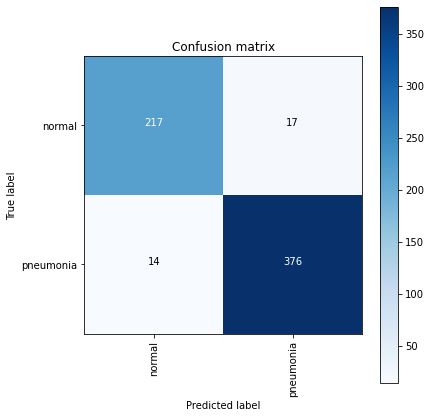

In [99]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

base_model_cnn = MobileNetV2(weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
        
# Freeze VGG layer
base_model_cnn.trainable = False

model_new10 = models.Sequential()
model_new10.add(base_model_cnn)
model_new10.add(layers.Flatten())
model_new10.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new10.add(layers.Dropout(0.2))
model_new10.add(layers.Dense(1,activation="sigmoid"))
model_new10.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new10 = model_new10.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=14, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new10, model_new10, test_images, test_y)
display(results_df)
plot_results(history__new10, model_new10, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new10.save(savepath)

##### 16) Pre-trained Augmented CNN 224x224 with VGG16

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 410s 16s/step - loss: 1.0576 - accuracy: 0.7706 - val_loss: 0.5006 - val_accuracy: 0.9050
Epoch 2/10
25/25 [==============================] - 413s 17s/step - loss: 0.4630 - accuracy: 0.8981 - val_loss: 0.4023 - val_accuracy: 0.9050
Epoch 3/10
25/25 [==============================] - 409s 16s/step - loss: 0.3682 - accuracy: 0.9044 - val_loss: 0.3406 - val_accuracy: 0.9150
Epoch 4/10
25/25 [==============================] - 408s 16s/step - loss: 0.3019 - accuracy: 0.9256 - val_loss: 0.2753 - val_accuracy: 0.9325
Epoch 5/10
25/25 [==============================] - 411s 16s/step - loss: 0.2832 - accuracy: 0.9312 - val_loss: 0.2320 - val_accuracy: 0.9500
Epoch 6/10
25/25 [==============================] - 408s 16s/step - loss: 0.3087 - accuracy: 0.9056 - val_loss: 0.3869 - val_accuracy: 0.8650
Epoch 7/10
25/25 [======

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


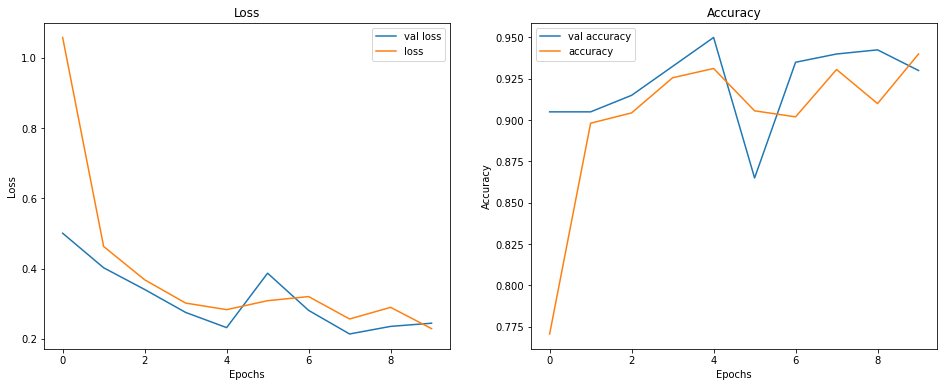

Test Accuracy = 0.93
Recall = 0.98


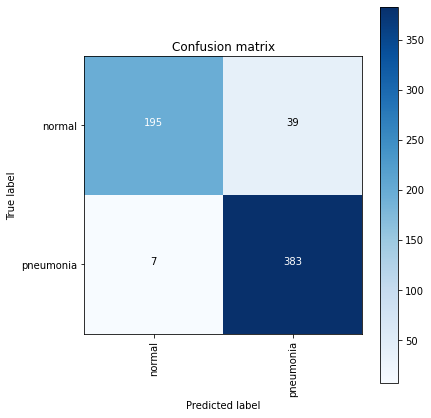

In [100]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 17) Pre-trained Augmented CNN 200x200 frozen layer VGG16

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 323s 13s/step - loss: 1.2146 - accuracy: 0.7925 - val_loss: 0.5586 - val_accuracy: 0.9350
Epoch 2/10
25/25 [==============================] - 353s 14s/step - loss: 0.5242 - accuracy: 0.8956 - val_loss: 0.4304 - val_accuracy: 0.9225
Epoch 3/10
25/25 [==============================] - 383s 15s/step - loss: 0.3729 - accuracy: 0.9255 - val_loss: 0.3234 - val_accuracy: 0.9400
Epoch 4/10
25/25 [==============================] - 335s 13s/step - loss: 0.3430 - accuracy: 0.9156 - val_loss: 0.3140 - val_accuracy: 0.9150
Epoch 5/10
25/25 [==============================] - 330s 13s/step - loss: 0.3053 - accuracy: 0.9187 - val_loss: 0.2680 - val_accuracy: 0.9450
Epoch 6/10
25/25 [==============================] - 391s 16s/step - loss: 0.2668 - accuracy: 0.9306 - val_loss: 0.2359 - val_accuracy: 0.9550
Epoch 7/10
25/25 [======

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


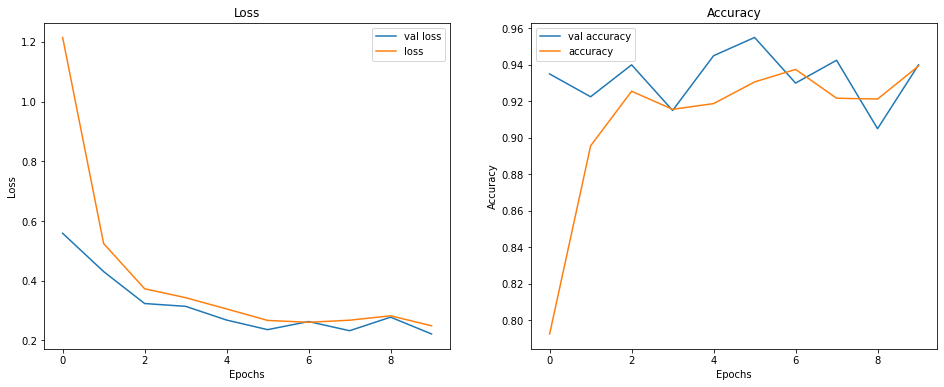

Test Accuracy = 0.93
Recall = 0.97


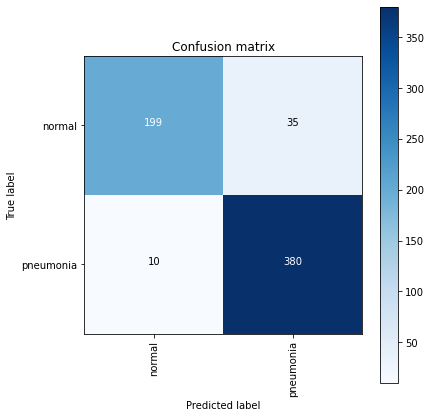

In [101]:
image_size = (200,200)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 200x200 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(200,200,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new3 = models.Sequential()
model_new3.add(base_model_cnn)
model_new3.add(layers.Flatten())
model_new3.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new3.add(layers.Dropout(0.2))
model_new3.add(layers.Dense(1,activation="sigmoid"))
model_new3.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])


start = time.time()
history__new3 = model_new3.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new3, model_new3, test_images, test_y)
display(results_df)
plot_results(history__new3, model_new3, test_images, test_y)
model_new3.save('data/models/model_new6.h5')
savepath = "./data/models/"+model_name+".h5"
model_new3.save(savepath)



In [163]:
results_df

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


##### Fine tuning
`

In [103]:
# Finall model has resolution 224x224, lets generate images in required resolution for this model:

test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

# Define best model
best_model = model_new10
test_images_in_resolution = test_images
test_images_labels = test_y
predictions = best_model.predict(test_images_in_resolution)
predictions_base = [1 if x > 0.5 else 0 for x in predictions]
test_accuracy_base = round(accuracy_score(test_images_labels, predictions_base),4)
test_recall_base = round(recall_score(test_images_labels, predictions_base),4)

Found 624 images belonging to 2 classes.


In [104]:
# Loop with changing prediction bondaries
list_of_thresholds = list(np.linspace(0.2, 0.8, 13))
list_of_options=[]
for threshold in list_of_thresholds:
    prediction_new = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_images_labels, prediction_new),4)
    test_recall = round(recall_score(test_images_labels, prediction_new),4)
    list_of_options.append((threshold, test_accuracy, test_recall))
    

In [105]:
# Base model predictions
print("Optimization focusen on accuracy")
print(f"Model accuracy {test_accuracy_base}. Model recall {test_recall_base}")


# Best prediction threshold for accuracy
threshold_acc = sorted(list_of_options, key = lambda x: x[1], reverse = True)[0]
print("Optimization focusen on accuracy")
print(f"Model accuracy {threshold_acc[1]}. Model recall {threshold_acc[2]}")


# Best prediction threshold for recall
threshold_recall = sorted(list_of_options, key = lambda x: x[2], reverse = True)[0]
print("Optimization focusen on recall")
print(f"Model accuracy {threshold_recall[1]}. Model recall {threshold_recall[2]}")



Optimization focusen on accuracy
Model accuracy 0.9503. Model recall 0.9641
Optimization focusen on accuracy
Model accuracy 0.9519. Model recall 0.9769
Optimization focusen on recall
Model accuracy 0.9135. Model recall 0.9949


Doubious cases investigation:
Doubious cases that were removed: 6.41%
Model accuracy after removal 0.9726. Model recall after removal 0.992


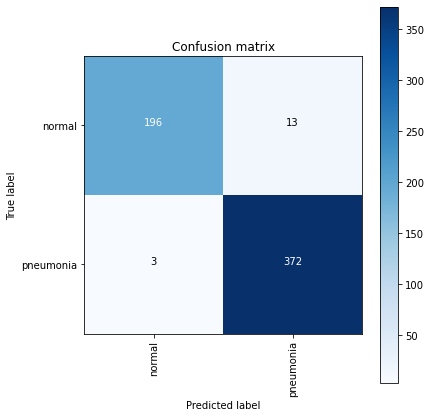

In [162]:
# Dubious cases removal
lower_border = 0.25
upper_border = 0.55
new_list = zip (test_images_labels, predictions)
new_predictions = [item for item in new_list if ((item[1] > upper_border) or (item[1] < lower_border))]
new_test_set = [new_prediction[0] for new_prediction in new_predictions]
new_predictions_after = [1 if x[1] > 0.5 else 0 for x in new_predictions]
new_accuracy = round(accuracy_score(new_test_set, new_predictions_after),4)
new_recall = round(recall_score(new_test_set, new_predictions_after),4)
print(f"Doubious cases investigation:")
print(f"Doubious cases that were removed: {round((1-len(new_predictions)/len(predictions))*100,2 )}%")
print(f"Model accuracy after removal {new_accuracy}. Model recall after removal {new_recall}")
confusion_mtx = confusion_matrix(new_test_set, new_predictions_after)
cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

# Conclusion
---
Based on results our finall model will be: "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

With the following parameters after tuning:

Accuracy - 0.9519

Recall - 0.9769

Because of the following reasons: 

1) It satisfy requirements on recall (higher 0.95).

2) It has high accuracy. 

Another solution for this problem might be identify cases that has probability between classes and send it to firther investigation by takeholder.
We are interested in maximizing racall (min FN) so we will remove prediction not equally from decision boundary, but we will drop cases with probabiblity 0.25-0.55 
This approach allows us to get accuracy 0.9726 and recall 0.992

Overall, this data tells us that current X-ray have enought information so we can be sure that each patient will be treated well. 